# 🖼️ Comprehensive Approaches to Multi-Label Image Classification:<br> From Data Augmentation to Semi-Supervised Learning

**Deep Learning — AUEB, Spring 2024/25**

|   | Team  Members             |          |                                                          |
|---|---------------------------|----------|----------------------------------------------------------|
| 1 |   Alviona Mancho          | f3322405 | alv.mantso@aueb.gr  / alviona.mantso@gmail.com           |
| 2 |   Anna Chatzipapadopoulou | f3322411 | ann.chatzipapadopoul@aueb.gr / annachatzipap@gmail.com   |                   

## Imports

In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.models import resnet50
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torch
from torchvision.models import densenet121
from timm import create_model
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.models import vit_b_16
from tqdm import tqdm
from sklearn.metrics import f1_score
from scipy.optimize import minimize
import random
from collections import defaultdict
import ast
import cv2
import math

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
images_folder = "/home/annachatz/Deep Learning/multilabel_modified/images/"
csv_file = "/home/annachatz/Deep Learning/multilabel_modified/multilabel_classification.csv"

# Load CSV
df = pd.read_csv(csv_file)

> **Note:**  
> We dropped rows containing `'desert'` in `Column2` because this value only appears in the column headers and not in the actual data. This helps ensure the data is clean and accurate for further analysis.


In [3]:
df = df[~df['Column2'].str.contains('desert', na=False)]

# Step 2: Reset the index
df.reset_index(drop=True, inplace=True)

In [4]:
df

Column1       Column2
0        Image_Name       Classes
1        image0.jpg              
2        image1.jpg    bus person
3        image2.jpg         sitar
4        image3.jpg        flutes
...             ...           ...
8562  image8964.img         trees
8563  image8965.img         trees
8564  image8966.img         trees
8565  image8967.img         trees
8566  image8968.img         trees

[8567 rows x 2 columns]

## Dataset Preparation

### Data Cleaning and Label Encoding Steps

1. **Filter Rows**  
   - Removed rows where `Column1` ends with `.img`.
   - Kept only rows where `Column1` contains `.jpg`, `Column2` is not empty, and `Column2` is not `'desert'`.

2. **Process the Labels Column**  
   - Split the values in `Column2` by spaces to create a list of labels for each image.

3. **Multi-Label Binarization**  
   - Used `MultiLabelBinarizer` to convert label lists into one-hot encoded columns.

4. **Add Encoded Labels**  
   - Added new columns for each label, with binary values indicating presence (1) or absence (0).

5. **Rename Columns**  
   - Renamed `Column1` to `'Image Name'` and `Column2` to `'Labels'` for clarity.


In [ ]:
# 1. Filter rows
df = df[~df['Column1'].str.endswith('.img', na=False)]
df.reset_index(drop=True, inplace=True)
df = df[
    (df['Column1'].str.contains('.jpg', na=False)) &
    (df['Column2'].str.strip() != '') &
    (df['Column2'] != 'desert')
]

# 2. Process the Labels column
df['Column2'] = df['Column2'].apply(lambda x: [label.strip() for label in x.split() if label.strip()] if isinstance(x, str) else [])

# 3. Multi-label binarizer to encode labels
mlb = MultiLabelBinarizer()
encoded_labels = mlb.fit_transform(df['Column2'])

# 4. Add encoded labels as separate columns
label_columns = mlb.classes_
for idx, label in enumerate(label_columns):
    df[label] = encoded_labels[:, idx]

# 5. Rename Columns
df = df.rename(columns={'Column1': 'Image Name', 'Column2': 'Labels'})

In [6]:
df

Image Name          Labels  boat  bus  cycle  ektara  flutes   
2        image1.jpg   [bus, person]     0    1      0       0       0  \
3        image2.jpg         [sitar]     0    0      0       0       0   
4        image3.jpg        [flutes]     0    0      0       0       1   
5        image4.jpg    [bus, trees]     0    1      0       0       0   
6        image5.jpg           [bus]     0    1      0       0       0   
...             ...             ...   ...  ...    ...     ...     ...   
6970  image6964.jpg  [truck, trees]     0    0      0       0       0   
6971  image6965.jpg  [truck, trees]     0    0      0       0       0   
6972  image6966.jpg  [truck, trees]     0    0      0       0       0   
6973  image6967.jpg  [truck, trees]     0    0      0       0       0   
6974  image6968.jpg  [truck, trees]     0    0      0       0       0   

      harmonium  motorcycle  mountains  person  sea  sitar  sunset  tabla   
2             0           0          0       1    0      0       0      0  \
3             0           0          0       0    0      1       0      0   
4             0           0          0       0    0      0       0      0   
5             0           0          0       0    0      0       0      0   
6             0           0          0       0    0      0       0      0   
...         ...         ...        ...     ...  ...    ...     ...    ...   
6970          0           0          0       0    0      0       0      0   
6971          0           0          0       0    0      0       0      0   
6972          0           0          0       0    0      0       0      0   
6973          0           0          0       0    0      0       0      0   
6974          0           0          0       0    0      0       0      0   

      trees  truck  
2         0      0  
3         0      0  
4         0      0  
5         1      0  
6         0      0  
...     ...    ...  
6970      1      1  
6971      1      1  
6972      1      1  
6973      1      1  
6974      1      1  

[6966 rows x 17 columns]

In [ ]:
# Assuming df is your DataFrame and 'Labels' column contains lists of labels per image
max_labels_per_image = df['Labels'].apply(len).max()
print(f"Maximum number of labels appearing in a single image: {max_labels_per_image}")

Maximum number of labels appearing in a single image: 6


In [ ]:
# Drop rows where the image path doesn't exist
df['full_path'] = df['Image Name'].apply(lambda x: os.path.join(images_folder, x))
df = df[df['full_path'].apply(os.path.exists)].reset_index(drop=True)

In [9]:
df

Image Name          Labels  boat  bus  cycle  ektara  flutes   
0        image1.jpg   [bus, person]     0    1      0       0       0  \
1        image2.jpg         [sitar]     0    0      0       0       0   
2        image3.jpg        [flutes]     0    0      0       0       1   
3        image4.jpg    [bus, trees]     0    1      0       0       0   
4        image5.jpg           [bus]     0    1      0       0       0   
...             ...             ...   ...  ...    ...     ...     ...   
6961  image6964.jpg  [truck, trees]     0    0      0       0       0   
6962  image6965.jpg  [truck, trees]     0    0      0       0       0   
6963  image6966.jpg  [truck, trees]     0    0      0       0       0   
6964  image6967.jpg  [truck, trees]     0    0      0       0       0   
6965  image6968.jpg  [truck, trees]     0    0      0       0       0   

      harmonium  motorcycle  mountains  person  sea  sitar  sunset  tabla   
0             0           0          0       1    0      0       0      0  \
1             0           0          0       0    0      1       0      0   
2             0           0          0       0    0      0       0      0   
3             0           0          0       0    0      0       0      0   
4             0           0          0       0    0      0       0      0   
...         ...         ...        ...     ...  ...    ...     ...    ...   
6961          0           0          0       0    0      0       0      0   
6962          0           0          0       0    0      0       0      0   
6963          0           0          0       0    0      0       0      0   
6964          0           0          0       0    0      0       0      0   
6965          0           0          0       0    0      0       0      0   

      trees  truck                                          full_path  
0         0      0  /home/annachatz/Deep Learning/multilabel_modif...  
1         0      0  /home/annachatz/Deep Learning/multilabel_modif...  
2         0      0  /home/annachatz/Deep Learning/multilabel_modif...  
3         1      0  /home/annachatz/Deep Learning/multilabel_modif...  
4         0      0  /home/annachatz/Deep Learning/multilabel_modif...  
...     ...    ...                                                ...  
6961      1      1  /home/annachatz/Deep Learning/multilabel_modif...  
6962      1      1  /home/annachatz/Deep Learning/multilabel_modif...  
6963      1      1  /home/annachatz/Deep Learning/multilabel_modif...  
6964      1      1  /home/annachatz/Deep Learning/multilabel_modif...  
6965      1      1  /home/annachatz/Deep Learning/multilabel_modif...  

[6966 rows x 18 columns]

### Train/Validation/Test Split

- **Step 1:** Split the main DataFrame into `train_df` (70%) and a temporary set (`temp_df`, 30%) using `train_test_split` with shuffling for randomness and a fixed `random_state` for reproducibility.
- **Step 2:** Further split `temp_df` equally into `val_df` (15% of original) and `test_df` (15% of original), again with shuffling and the same random seed.

This ensures a 70/15/15 split between training, validation, and test sets.

In [40]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)

# Step 2: Split temp into val and dev
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

### DataLoader Preparation

- **`MultiLabelDataset`**:  
  Wraps the training and validation data, applying a simple image transform pipeline.
  - Images are resized to 224×224, converted to tensors, and normalized with standard ImageNet statistics.
- **Train/Validation Datasets**:  
  - `train_dataset`: Uses the training DataFrame and transformation.
  - `val_dataset`: Uses the validation DataFrame and transformation.
- **DataLoaders**:  
  - `train_loader`: Loads batches of 32 training samples with shuffling.
  - `val_loader`: Loads batches of 32 validation samples without shuffling.

In [ ]:
class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = dataframe.drop(columns=['Image Name', 'Labels', 'full_path']).values
        self.img_paths = dataframe['full_path'].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        labels = torch.from_numpy(np.array(self.labels[idx], dtype=np.float32))

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, labels

In [14]:
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Just resize
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard normalization
                         std=[0.229, 0.224, 0.225]),
])

In [41]:
train_dataset = MultiLabelDataset(train_df, transform=simple_transform)
val_dataset = MultiLabelDataset(val_df, transform=simple_transform)
test_dataset = MultiLabelDataset(test_df, transform=simple_transform)

In [42]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Multi-Label Classification Using Transfer Learning

In this part we use pre-trained models to reduce training time and improve performance with limited data.

In [15]:
print(label_columns)

['boat' 'bus' 'cycle' 'ektara' 'flutes' 'harmonium' 'motorcycle'
 'mountains' 'person' 'sea' 'sitar' 'sunset' 'tabla' 'trees' 'truck']


In [16]:
num_classes = len(label_columns) 

### Using ResNet50 for Multi-Label Classification
**Base Architecture:**  
- **ResNet50** is a widely used deep convolutional neural network with 50 layers.
- It uses *residual connections* (skip connections) that allow gradients to flow directly through the network, making it possible to train very deep architectures effectively.
- The original model ends with a fully connected (fc) layer that outputs 1,000 logits (for ImageNet’s 1,000 classes).

**Modification for Multi-Label Tasks:**  
- For multi-label image classification, we need the model to predict the presence or absence of each label independently for every image.
- To do this, we *replace the final fc layer* with a new one:
  ```python
  model.fc = nn.Linear(model.fc.in_features, num_classes)

In [48]:
model = resnet50(pretrained=True)

# Replace the final layer to match the number of labels
num_classes = len(label_columns)  # Number of unique labels in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust output layer

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
# Loss function
criterion = nn.BCEWithLogitsLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#### Model Training and Validation Loop

- **Training Loop:**  
  - For a set number of epochs (`num_epochs`), the model is set to training mode.
  - Each batch from the training DataLoader is sent to the device.
  - Gradients are zeroed, and a forward pass computes model outputs.
  - The loss (using the chosen criterion, e.g., BCEWithLogitsLoss for multi-label classification) is computed and backpropagated.
  - Model parameters are updated with the optimizer.
  - The average training loss for each epoch is printed.

- **Validation Phase:**  
  - After each training epoch, the model is switched to evaluation mode (disabling dropout, etc.).
  - The validation DataLoader is used to calculate the average validation loss without updating the model weights.

- **Model Saving:**  
  - After training, the model’s weights are saved to a `.pth` file for future use or further fine-tuning.

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


torch.save(model.state_dict(), 'resnet50.pth')
print("Model saved successfully!")

Epoch [1/5], Loss: 0.1473
Validation Loss: 0.0733
Epoch [2/5], Loss: 0.0638
Validation Loss: 0.0736
Epoch [3/5], Loss: 0.0454
Validation Loss: 0.0749
Epoch [4/5], Loss: 0.0318
Validation Loss: 0.0697
Epoch [5/5], Loss: 0.0254
Validation Loss: 0.0730
Model saved successfully!


In [51]:
# Predict on test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       1.00      0.98      0.99       237
         bus       0.98      0.96      0.97        92
       cycle       0.97      0.99      0.98       226
      ektara       0.91      0.91      0.91        22
      flutes       0.89      0.81      0.85        42
   harmonium       0.89      0.74      0.81        34
  motorcycle       0.99      0.92      0.95       159
   mountains       0.69      0.31      0.43        29
      person       0.87      0.77      0.82       332
         sea       0.95      0.93      0.94       240
       sitar       0.83      0.85      0.84        34
      sunset       0.92      0.73      0.81        15
       tabla       0.94      0.96      0.95       125
       trees       0.88      0.74      0.80       223
       truck       0.94      0.99      0.96       139

   micro avg       0.94      0.88      0.91      1949
   macro avg       0.91      0.84      0.87      1949
weighted avg       0.93   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Below we visualize a batch of validation images alongside their ground truth and predicted labels.

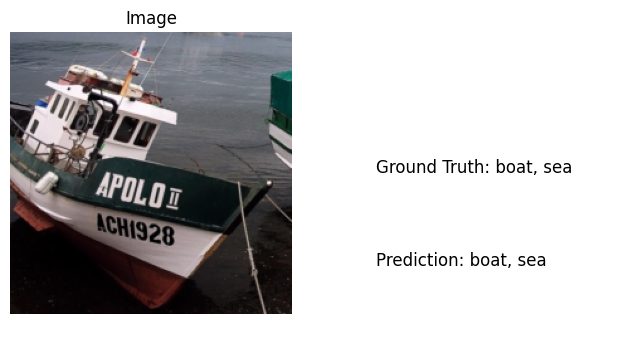

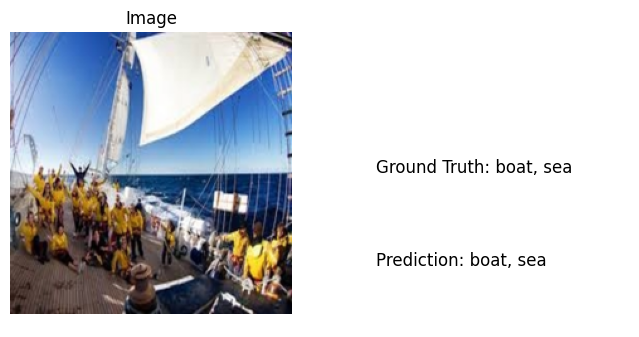

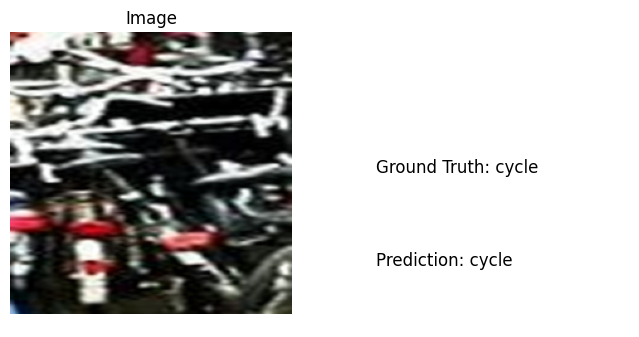

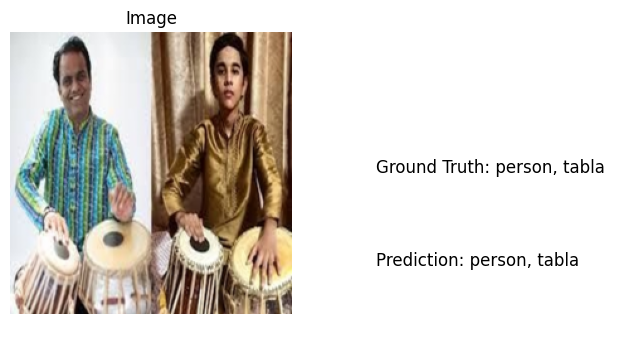

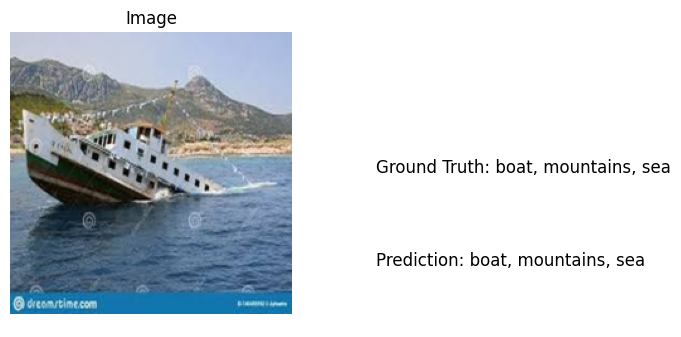

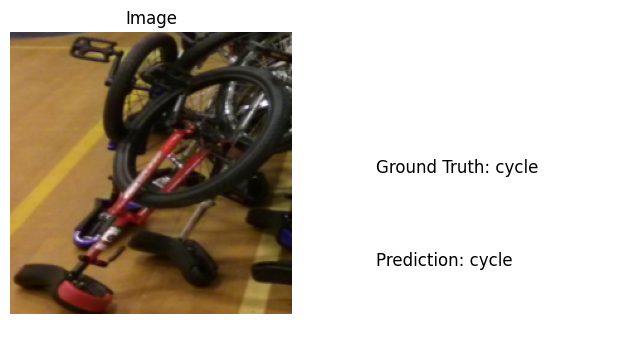

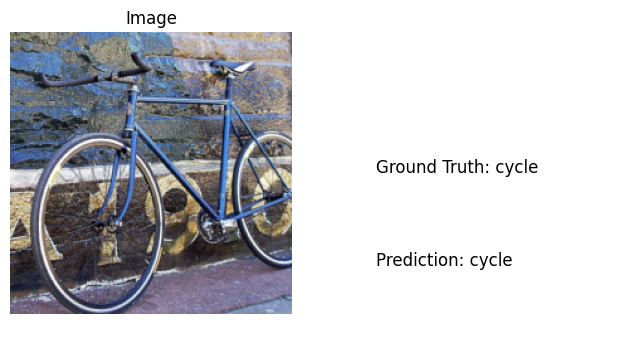

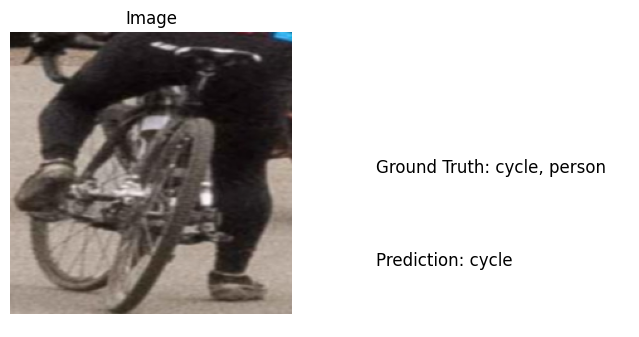

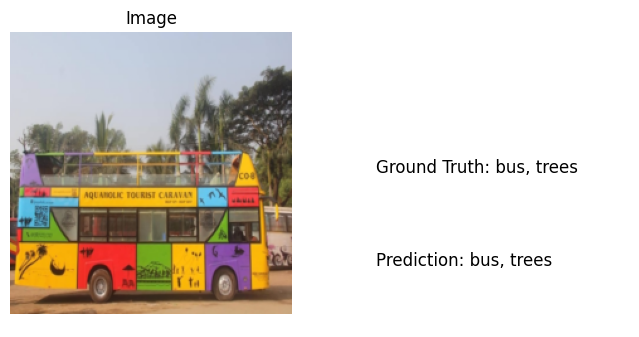

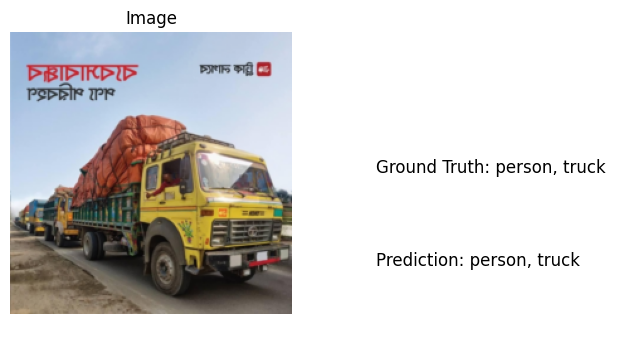

In [ ]:
# Helper function to unnormalize an image
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img = img.clone()
    img = img * std[:, None, None] + mean[:, None, None]
    return img

# Helper function to plot images with predictions and ground truth
def plot_predictions(model, data_loader, label_columns, device):
    model.eval()
    images, labels = next(iter(data_loader))  # Get a batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold for binary predictions

    # Select a few examples to visualize
    num_examples = min(10, len(images))
    images = images[:num_examples].cpu()
    labels = labels[:num_examples].cpu()
    predictions = predictions[:num_examples].cpu()

    for i in range(num_examples):
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        img = unnormalize(images[i])
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Image")

        plt.subplot(1, 2, 2)
        true_labels = [label_columns[j] for j, val in enumerate(labels[i]) if val == 1]
        pred_labels = [label_columns[j] for j, val in enumerate(predictions[i]) if val == 1]
        plt.text(0.1, 0.5, f"Ground Truth: {', '.join(true_labels)}", fontsize=12)
        plt.text(0.1, 0.2, f"Prediction: {', '.join(pred_labels)}", fontsize=12)
        plt.axis('off')

        plt.show()

plot_predictions(model, val_loader, label_columns, device)


### Using EfficientNet-B0 for Multi-Label Classification

- **EfficientNet-B0 Architecture:**  
  EfficientNet is a family of convolutional neural networks known for achieving high accuracy with fewer parameters and computations. EfficientNet-B0, the smallest model in the series, uses a combination of depthwise separable convolutions and a compound scaling method to balance network depth, width, and input resolution efficiently.
  
- **Modification for Multi-Label Output:**  
  The original final classification layer (`classifier`) is replaced to match the number of unique labels in our dataset:
  ```python
  model.classifier = nn.Linear(model.classifier.in_features, num_classes)

In [52]:
model = create_model('efficientnet_b0', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

In [53]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


torch.save(model.state_dict(), 'efficientb0.pth')
print("Model saved successfully!")

Epoch [1/5], Loss: 0.2781
Validation Loss: 0.1183
Epoch [2/5], Loss: 0.1003
Validation Loss: 0.0825
Epoch [3/5], Loss: 0.0712
Validation Loss: 0.0720
Epoch [4/5], Loss: 0.0551
Validation Loss: 0.0666
Epoch [5/5], Loss: 0.0454
Validation Loss: 0.0674
Model saved successfully!


In [ ]:
# Predict on test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       0.99      1.00      0.99       237
         bus       0.98      0.97      0.97        92
       cycle       0.98      0.98      0.98       226
      ektara       0.83      0.91      0.87        22
      flutes       0.86      0.76      0.81        42
   harmonium       0.82      0.79      0.81        34
  motorcycle       0.98      0.92      0.95       159
   mountains       1.00      0.03      0.07        29
      person       0.85      0.81      0.83       332
         sea       0.95      0.95      0.95       240
       sitar       0.79      0.91      0.85        34
      sunset       0.86      0.40      0.55        15
       tabla       0.92      0.98      0.95       125
       trees       0.89      0.80      0.84       223
       truck       0.97      0.97      0.97       139

   micro avg       0.93      0.89      0.91      1949
   macro avg       0.91      0.81      0.83      1949
weighted avg       0.93   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Using DenseNet-121 for Multi-Label Classification

- **DenseNet-121 Architecture:**  
  DenseNet-121 is a deep convolutional neural network characterized by its *dense connectivity*: each layer receives input from all preceding layers and passes its own feature maps to all subsequent layers within a block. This design encourages feature reuse, improves information flow, and helps mitigate the vanishing gradient problem in deep networks. The “121” refers to the total number of layers in the model.

- **Modification for Multi-Label Output:**  
  The original classification layer (`classifier`) is replaced to match the number of labels in our dataset:
  ```python
  model.classifier = nn.Linear(model.classifier.in_features, num_classes)

In [28]:
model = densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)


/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")

torch.save(model.state_dict(), 'densenet121.pth')
print("Model saved successfully!")


Epoch [1/5], Loss: 0.2090
Validation Loss: 0.0980
Epoch [2/5], Loss: 0.0834
Validation Loss: 0.0742
Epoch [3/5], Loss: 0.0583
Validation Loss: 0.0665
Epoch [4/5], Loss: 0.0422
Validation Loss: 0.0635
Epoch [5/5], Loss: 0.0337
Validation Loss: 0.0681
Model saved successfully!


In [ ]:
# Predict on test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       0.99      0.99      0.99       237
         bus       0.97      0.97      0.97        92
       cycle       0.99      0.98      0.98       226
      ektara       0.95      0.91      0.93        22
      flutes       0.89      0.76      0.82        42
   harmonium       0.81      0.76      0.79        34
  motorcycle       1.00      0.90      0.95       159
   mountains       0.92      0.38      0.54        29
      person       0.92      0.73      0.81       332
         sea       0.95      0.95      0.95       240
       sitar       0.82      0.82      0.82        34
      sunset       0.73      0.53      0.62        15
       tabla       0.93      0.99      0.96       125
       trees       0.85      0.75      0.80       223
       truck       0.97      0.95      0.96       139

   micro avg       0.94      0.88      0.91      1949
   macro avg       0.91      0.83      0.86      1949
weighted avg       0.94   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Using ViT-B/16 (Vision Transformer) for Multi-Label Classification

- **ViT-B/16 Architecture:**  
  Vision Transformer (ViT-B/16) is a deep learning model that applies transformer architectures—originally designed for natural language processing—to images. It splits each image into 16×16 pixel patches, flattens them, and treats each patch as a “token” (like a word in a sentence). These tokens are then processed by transformer encoder blocks that use self-attention to learn global relationships between image regions, enabling strong representation learning without convolutional layers. The “B/16” means “Base” size (12 layers) and patch size 16.

- **Modification for Multi-Label Output:**  
  The final classification head (`model.heads.head`) is replaced with a new fully connected layer:
  ```python
  model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

In [ ]:
model = vit_b_16(pretrained=True)
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")

torch.save(model.state_dict(), 'vit.pth')
print("Model saved successfully!")

Epoch [1/5], Loss: 0.1310
Validation Loss: 0.0823
Epoch [2/5], Loss: 0.0626
Validation Loss: 0.0721
Epoch [3/5], Loss: 0.0449
Validation Loss: 0.0721
Epoch [4/5], Loss: 0.0345
Validation Loss: 0.0651
Epoch [5/5], Loss: 0.0255
Validation Loss: 0.0643
Model saved successfully!


In [ ]:
# Predict on test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       1.00      1.00      1.00       237
         bus       0.97      0.96      0.96        92
       cycle       0.96      0.98      0.97       226
      ektara       0.91      0.91      0.91        22
      flutes       0.84      0.88      0.86        42
   harmonium       0.84      0.76      0.80        34
  motorcycle       1.00      0.89      0.94       159
   mountains       0.66      0.66      0.66        29
      person       0.87      0.79      0.83       332
         sea       0.96      0.94      0.95       240
       sitar       0.89      0.91      0.90        34
      sunset       0.82      0.60      0.69        15
       tabla       0.96      0.94      0.95       125
       trees       0.86      0.75      0.80       223
       truck       0.97      0.97      0.97       139

   micro avg       0.93      0.89      0.91      1949
   macro avg       0.90      0.86      0.88      1949
weighted avg       0.93   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Using DeiT-base/16 for Multi-Label Classification

- **DeiT-base/16 Architecture:**  
  DeiT (Data-efficient Image Transformer) is a vision transformer designed to work well with less training data and without requiring huge labeled datasets. Like ViT, DeiT splits input images into 16×16 patches, embeds them as tokens, and processes them through multiple transformer encoder layers using self-attention. DeiT introduces innovative training strategies (such as knowledge distillation with a “distillation token”) to improve performance and data efficiency.

- **Modification for Multi-Label Output:**  
  The original final classification layer (`head`) is replaced to support multi-label outputs:
  ```python
  model.head = nn.Linear(model.head.in_features, num_classes)

In [34]:
model = create_model('deit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, num_classes)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")

torch.save(model.state_dict(), 'deit.pth')
print("Model saved successfully!")


Epoch [1/5], Loss: 0.1172
Validation Loss: 0.0670
Epoch [2/5], Loss: 0.0475
Validation Loss: 0.0578
Epoch [3/5], Loss: 0.0289
Validation Loss: 0.0564
Epoch [4/5], Loss: 0.0204
Validation Loss: 0.0599
Epoch [5/5], Loss: 0.0159
Validation Loss: 0.0647
Model saved successfully!


In [ ]:
# Predict on test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       1.00      0.99      1.00       237
         bus       0.99      0.97      0.98        92
       cycle       0.97      0.99      0.98       226
      ektara       0.91      0.95      0.93        22
      flutes       0.79      0.88      0.83        42
   harmonium       0.82      0.79      0.81        34
  motorcycle       1.00      0.94      0.97       159
   mountains       0.82      0.62      0.71        29
      person       0.91      0.73      0.81       332
         sea       0.96      0.96      0.96       240
       sitar       0.79      0.91      0.85        34
      sunset       1.00      0.53      0.70        15
       tabla       0.91      1.00      0.95       125
       trees       0.81      0.86      0.83       223
       truck       0.97      0.99      0.98       139

   micro avg       0.93      0.91      0.92      1949
   macro avg       0.91      0.87      0.89      1949
weighted avg       0.93   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Ensemble Prediction (Average)

- **Ensemble Setup:**  
  We combine several independently trained models (ResNet, DenseNet, EfficientNet, ViT, DeiT) to make predictions as a group, rather than relying on a single model. Model ensembles reduce variance and can help compensate for the individual weaknesses of each architecture, often improving overall accuracy and generalization on unseen data.

- **How the Ensemble Works:**  
  - For each input batch, all models in the list are used to make predictions.
  - Each model outputs multi-label logits, which are passed through a sigmoid to get probability scores for each class.
  - The predictions from all models are stacked and then averaged across models to produce a final consensus prediction for each label.

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(label_columns) 

# Load ResNet
resnet = resnet50(pretrained=False)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
resnet.load_state_dict(torch.load('resnet50.pth'))
resnet.to(device)
resnet.eval()

# Load DenseNet
densenet = densenet121(pretrained=False)
densenet.classifier = torch.nn.Linear(densenet.classifier.in_features, num_classes)
densenet.load_state_dict(torch.load('densenet121.pth'))
densenet.to(device)
densenet.eval()

# Load EfficientNet
efficientnet = create_model('efficientnet_b0', pretrained=False, num_classes=num_classes)
efficientnet.load_state_dict(torch.load('efficientb0.pth'))
efficientnet.to(device)
efficientnet.eval()

# Load ViT
vit = vit_b_16(pretrained=False)  # no need pretrained, since you are loading your weights
vit.heads.head = torch.nn.Linear(vit.heads.head.in_features, num_classes)
vit.load_state_dict(torch.load('vit.pth'))
vit.to(device)
vit.eval()

# Load DeiT
deit = create_model('deit_base_patch16_224', pretrained=False, num_classes=num_classes)
deit.load_state_dict(torch.load('deit.pth'))
deit.to(device)
deit.eval()


/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_3060344/1379300785.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `w

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [65]:
models = [resnet, densenet, efficientnet, vit, deit]

In [66]:
def ensemble_predict(models, images):
    outputs = []
    for model in models:
        with torch.no_grad():
            out = model(images)
            outputs.append(torch.sigmoid(out))  # Apply sigmoid for multi-label

    outputs = torch.stack(outputs, dim=0)  # (num_models, batch_size, num_classes)
    outputs = outputs.mean(dim=0)           # Average over models
    return outputs


In [ ]:
all_labels = []
all_predictions = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    # Ensemble prediction
    outputs = ensemble_predict(models, images)

    predictions = (outputs > 0.5).float()  # Apply 0.5 threshold

    all_labels.append(labels.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

# Stack all the results
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Print classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))

              precision    recall  f1-score   support

        boat       1.00      1.00      1.00       237
         bus       0.98      0.97      0.97        92
       cycle       0.98      0.99      0.98       226
      ektara       0.91      0.95      0.93        22
      flutes       0.85      0.83      0.84        42
   harmonium       0.84      0.76      0.80        34
  motorcycle       1.00      0.92      0.96       159
   mountains       0.92      0.38      0.54        29
      person       0.91      0.77      0.84       332
         sea       0.96      0.95      0.95       240
       sitar       0.84      0.91      0.87        34
      sunset       0.89      0.53      0.67        15
       tabla       0.93      1.00      0.96       125
       trees       0.88      0.79      0.83       223
       truck       0.97      0.97      0.97       139

   micro avg       0.95      0.90      0.92      1949
   macro avg       0.92      0.85      0.87      1949
weighted avg       0.94   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Ensemble Prediction (Majority Voting)

- **Majority Voting Ensemble:**  
  Instead of averaging probabilities, this approach combines the binary predictions from each model by letting each model “vote” on the presence or absence of each label.
  
- **How It Works:**  
  1. Each model predicts a binary (0 or 1) label for each class using a sigmoid threshold.
  2. The predictions from all models are stacked and summed.
  3. For each class, if at least $k$ of the models predict a label as present (votes ≥ 50%), the final prediction for that label is set to 1 (present); otherwise, it is 0 (absent).

In [72]:
def ensemble_predict_majority_vote(models, images):
    all_preds = []
    for model in models:
        with torch.no_grad():
            out = model(images)
            out = torch.sigmoid(out)  # Turn logits into probabilities
            pred = (out > 0.5).float()  # Convert to binary (0 or 1)
            all_preds.append(pred)

    # Stack all predictions: shape (num_models, batch_size, num_classes)
    all_preds = torch.stack(all_preds, dim=0)

    # Sum across models
    votes = all_preds.sum(dim=0)

    # If votes >= half models → final prediction is 1
    majority_threshold = len(models) / 2
    # majority_threshold = 4
    final_preds = (votes >= majority_threshold).float()

    return final_preds


We first examine the case where a label is marked as present only if at least $k=4$ models, predict it.

In [71]:
all_labels = []
all_predictions = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    # Ensemble prediction with majority voting
    predictions = ensemble_predict_majority_vote(models, images)

    all_labels.append(labels.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       1.00      0.99      0.99       237
         bus       0.99      0.97      0.98        92
       cycle       0.98      0.98      0.98       226
      ektara       0.95      0.91      0.93        22
      flutes       0.89      0.81      0.85        42
   harmonium       0.83      0.74      0.78        34
  motorcycle       1.00      0.90      0.95       159
   mountains       0.90      0.31      0.46        29
      person       0.93      0.71      0.80       332
         sea       0.96      0.93      0.95       240
       sitar       0.83      0.85      0.84        34
      sunset       1.00      0.40      0.57        15
       tabla       0.94      0.96      0.95       125
       trees       0.91      0.70      0.79       223
       truck       0.98      0.96      0.97       139

   micro avg       0.96      0.86      0.91      1949
   macro avg       0.94      0.81      0.85      1949
weighted avg       0.96   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Then, we examine the case where a label is marked as present only if at least $k=3$ models, predict it.

In [73]:
all_labels = []
all_predictions = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    # Ensemble prediction with majority voting
    predictions = ensemble_predict_majority_vote(models, images)

    all_labels.append(labels.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       1.00      1.00      1.00       237
         bus       0.97      0.97      0.97        92
       cycle       0.98      0.99      0.98       226
      ektara       0.91      0.95      0.93        22
      flutes       0.88      0.83      0.85        42
   harmonium       0.84      0.76      0.80        34
  motorcycle       1.00      0.92      0.96       159
   mountains       0.91      0.34      0.50        29
      person       0.90      0.78      0.84       332
         sea       0.96      0.95      0.95       240
       sitar       0.84      0.91      0.87        34
      sunset       0.89      0.53      0.67        15
       tabla       0.93      0.99      0.96       125
       trees       0.89      0.79      0.84       223
       truck       0.97      0.98      0.97       139

   micro avg       0.95      0.90      0.92      1949
   macro avg       0.92      0.85      0.87      1949
weighted avg       0.94   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Optimizing Ensemble Weights for Multi-Label Prediction

- **Collecting Model Outputs:**  
  - For each batch in the validation set, raw (sigmoid) prediction probabilities from each model are stored, as well as the true labels.
  - This allows post-hoc combination and analysis of different ensemble strategies.

- **Weighted Ensemble:**  
  - Instead of treating all models equally, this method finds the optimal weights for each model’s output when combining their predictions.
  - For a given set of weights, each model’s probabilities are multiplied by its weight and summed.
  - A fixed threshold (e.g., 0.5) is applied to convert the weighted sum into binary predictions.

- **Performance Metric:**  
  - The **macro F1 score** (which gives equal importance to each class) is computed between the weighted ensemble predictions and the ground truth labels.
  - The function returns the negative F1 score so that optimization algorithms (like `scipy.optimize.minimize`) can maximize F1 by minimizing its negative.

In [ ]:
# Collect raw outputs from each model
raw_outputs = [[] for _ in range(len(models))]
all_labels = []

for images, labels in tqdm(val_loader):
    images, labels = images.to(device), labels.to(device)

    for i, model in enumerate(models):
        with torch.no_grad():
            out = torch.sigmoid(model(images))  # (batch_size, num_classes)
            raw_outputs[i].append(out.cpu().numpy())

    all_labels.append(labels.cpu().numpy())

raw_outputs = [np.vstack(out) for out in raw_outputs]  # List of arrays (n_samples, n_classes)
all_labels = np.vstack(all_labels)  # (n_samples, n_classes)


100%|██████████| 33/33 [00:13<00:00,  2.37it/s]


In [ ]:
def evaluate_weights(weights, raw_outputs, true_labels, threshold=0.5):
    # weighted sum
    weighted_output = np.zeros_like(raw_outputs[0])
    for w, out in zip(weights, raw_outputs):
        weighted_output += w * out

    # Apply threshold
    preds = (weighted_output > threshold).astype(int)

    # Calculate Macro F1 score (multi-label setting)
    f1 = f1_score(true_labels, preds, average='macro')
    return -f1  # Minimize -f1 => maximize f1


In [46]:
# Start with equal weights
initial_weights = np.ones(len(models)) / len(models)

# Constraint: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda w: 1 - sum(w)})

# Bounds: each weight between 0 and 1
bounds = [(0, 1)] * len(models)

# Run optimizer
result = minimize(evaluate_weights,
                  initial_weights,
                  args=(raw_outputs, all_labels),
                  method='SLSQP',
                  bounds=bounds,
                  constraints=constraints)

# Best found weights
best_weights = result.x

print("Best Ensemble Weights:", best_weights)


Best Ensemble Weights: [0.2 0.2 0.2 0.2 0.2]


**Conclusion:**  
After optimization, the best performance was achieved when all five models were given equal weights (0.2 each). This suggests that each model contributes similarly and that a simple average of their predictions is the most effective strategy for this ensemble on the validation set.

## Addressing Class Imbalance with Targeted Data Augmentation

### Label Distribution in the Training Set

The bar plot below shows the frequency of each label in the training data. As seen in the plot, some labels are much less common (rare) than others, which could make it challenging for the model to learn to predict these underrepresented classes.

**To address this class imbalance, we will apply targeted data augmentation strategies to increase the representation of rare labels in the training set and help improve the model's ability to generalize to all classes.**

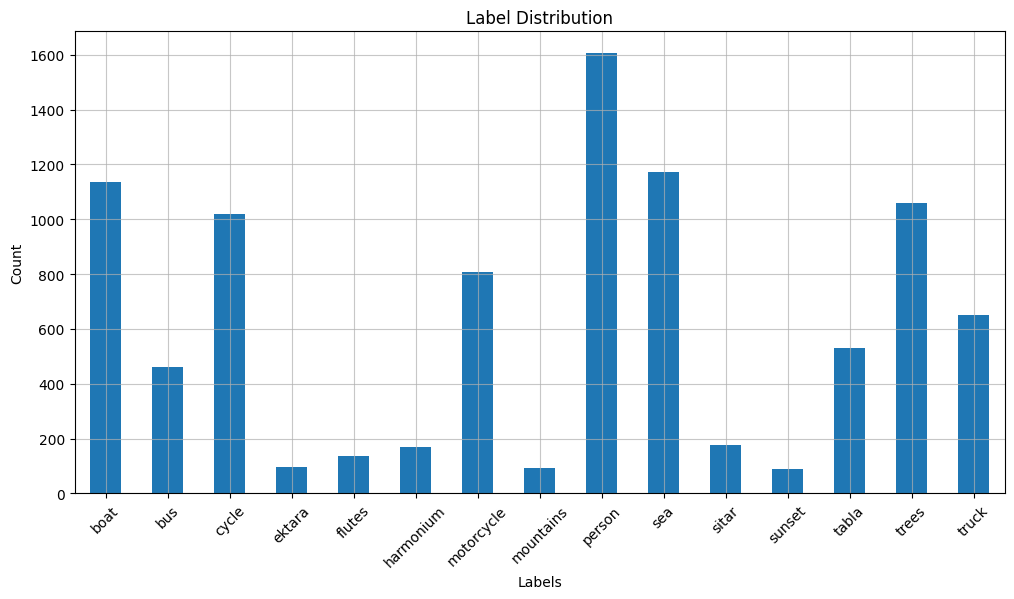

In [16]:
label_counts = train_df[label_columns].sum()
plt.figure(figsize=(12, 6))
label_counts.plot(kind="bar")
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(alpha=0.7)
plt.savefig("label_distribution.png", dpi=300)
plt.show()


In [25]:
df

Image Name          Labels  boat  bus  cycle  ektara  flutes   
0        image1.jpg   [bus, person]     0    1      0       0       0  \
1        image2.jpg         [sitar]     0    0      0       0       0   
2        image3.jpg        [flutes]     0    0      0       0       1   
3        image4.jpg    [bus, trees]     0    1      0       0       0   
4        image5.jpg           [bus]     0    1      0       0       0   
...             ...             ...   ...  ...    ...     ...     ...   
6961  image6964.jpg  [truck, trees]     0    0      0       0       0   
6962  image6965.jpg  [truck, trees]     0    0      0       0       0   
6963  image6966.jpg  [truck, trees]     0    0      0       0       0   
6964  image6967.jpg  [truck, trees]     0    0      0       0       0   
6965  image6968.jpg  [truck, trees]     0    0      0       0       0   

      harmonium  motorcycle  mountains  person  sea  sitar  sunset  tabla   
0             0           0          0       1    0      0       0      0  \
1             0           0          0       0    0      1       0      0   
2             0           0          0       0    0      0       0      0   
3             0           0          0       0    0      0       0      0   
4             0           0          0       0    0      0       0      0   
...         ...         ...        ...     ...  ...    ...     ...    ...   
6961          0           0          0       0    0      0       0      0   
6962          0           0          0       0    0      0       0      0   
6963          0           0          0       0    0      0       0      0   
6964          0           0          0       0    0      0       0      0   
6965          0           0          0       0    0      0       0      0   

      trees  truck                                          full_path  
0         0      0  /home/annachatz/Deep Learning/multilabel_modif...  
1         0      0  /home/annachatz/Deep Learning/multilabel_modif...  
2         0      0  /home/annachatz/Deep Learning/multilabel_modif...  
3         1      0  /home/annachatz/Deep Learning/multilabel_modif...  
4         0      0  /home/annachatz/Deep Learning/multilabel_modif...  
...     ...    ...                                                ...  
6961      1      1  /home/annachatz/Deep Learning/multilabel_modif...  
6962      1      1  /home/annachatz/Deep Learning/multilabel_modif...  
6963      1      1  /home/annachatz/Deep Learning/multilabel_modif...  
6964      1      1  /home/annachatz/Deep Learning/multilabel_modif...  
6965      1      1  /home/annachatz/Deep Learning/multilabel_modif...  

[6966 rows x 18 columns]

**Goal:** To increase the number of training samples for rare (underrepresented) labels and improve the model’s ability to learn these classes.

  1. **Identify Underrepresented Labels:**  
     - Finds all labels that appear fewer than a set threshold (e.g., 200 times) in the training set.
  2. **Collect Source Images:**  
     - For each underrepresented label, gathers all images containing that label.
  3. **Apply Augmentations:**  
     - Generates new synthetic images by randomly applying augmentations such as flips, rotations, color jitter, and random crops to images with rare labels.
     - Augmentation continues for each rare label until it has at least a target number of samples (e.g., 400).
  4. **Save Augmented Data:**  
     - Each new image is saved to disk with a unique name, and its metadata (including label information and file path) is added to a new DataFrame.
     - One-hot encoding is applied to the labels for compatibility with the training pipeline.
  5. **Export the Combined Dataset:**  
     - The augmented samples are combined with the original training set and saved as a new CSV file for downstream training.

**Result:** The training dataset will have a more balanced distribution of labels, which should help the model learn to recognize rare classes more effectively.

In [ ]:
# Paths
image_dir = "/home/annachatz/Deep Learning/multilabel_modified/images/"
csv_path = "/home/annachatz/Deep Learning/multilabel_modified/multilabel_classification.csv"
output_dir = os.path.join(image_dir, "augmented")
os.makedirs(output_dir, exist_ok=True)

train_df['Labels'] = train_df['Labels'].apply(lambda x: x if isinstance(x, list) else ast.literal_eval(x))

# Count label frequencies
label_counts = defaultdict(int)
for labels in train_df['Labels']:
    for label in labels:
        label_counts[label] += 1

# Select underrepresented classes
min_required = 400
threshold = 200
underrepresented = {label for label, count in label_counts.items() if count < threshold}
print("Underrepresented labels:", underrepresented)

# Map label to image samples
label_to_images = defaultdict(list)
for idx, row in train_df.iterrows():
    for label in row['Labels']:
        if label in underrepresented:
            label_to_images[label].append(row)

# Define augmentation transforms
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor()
])
to_pil = transforms.ToPILImage()

# Generate augmented images
augmented_rows = []
for label in underrepresented:
    samples = label_to_images[label]
    current_count = label_counts[label]
    i = 0
    pbar = tqdm(total=min_required - current_count, desc=f"Augmenting '{label}'")

    while label_counts[label] < min_required:
        sample_row = random.choice(samples)
        img_name = sample_row['Image Name']
        labels = sample_row['Labels']
        img_path = sample_row['full_path']

        try:
            image = Image.open(img_path).convert('RGB')
            aug_image = to_pil(augmentation(image))

            new_name = f"aug_{label}_{i}_{img_name}"
            aug_image_path = os.path.join(output_dir, new_name)
            aug_image.save(aug_image_path)

            # Create row with all columns
            row_data = {
                'Image Name': new_name,
                'Labels': labels,
                'full_path': aug_image_path
            }

            # One-hot encoding
            for col in train_df.columns:
                if col not in ['Image Name', 'Labels', 'full_path']:
                    row_data[col] = 1 if col in labels else 0

            augmented_rows.append(row_data)

            for lbl in labels:
                label_counts[lbl] += 1

            i += 1
            pbar.update(1)
        except Exception as e:
            print(f"Failed to process {img_path}: {e}")
    pbar.close()

# Combine and save
augmented_df = pd.DataFrame(augmented_rows)
combined_df = pd.concat([train_df, augmented_df], ignore_index=True)
augmented_csv_path = csv_path.replace(".csv", "_augmented.csv")
combined_df.to_csv(augmented_csv_path, index=False)

print(f"✅ Augmentation complete. Augmented CSV saved as: {augmented_csv_path}")


Underrepresented labels: {'flutes', 'sitar', 'mountains', 'harmonium', 'sunset', 'ektara'}


Augmenting 'flutes':   5%|▍         | 13/262 [00:00<00:07, 33.83it/s]

Augmenting 'ektara': 100%|██████████| 249/249 [00:10<00:00, 24.17it/s]


✅ Augmentation complete. Augmented CSV saved as: /home/annachatz/Deep Learning/multilabel_modified/multilabel_classification_augmented.csv


In [80]:
combined_df = pd.concat([train_df, augmented_df], ignore_index=True)

In [81]:
train_df = combined_df

### Fine-Tuning ResNet50 with Augmented Data

- We load a pre-trained ResNet50 model to leverage its powerful feature extraction capabilities, gained from training on the large ImageNet dataset.
- The final classification layer is replaced so the model outputs the correct number of scores for our multi-label task.
- This model will be **fine-tuned using our augmented training dataset** (which now includes extra samples for underrepresented labels), helping it learn more robust and balanced representations for all classes.
- By combining transfer learning with targeted data augmentation, we aim to improve the model’s performance—especially for rare or minority classes.

In [ ]:
model = resnet50(pretrained=True)
# Replace the final layer to match the number of labels
num_classes = len(label_columns)  # Number of unique labels in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust output layer

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [74]:
train_df

Image Name                   Labels  boat  bus  cycle   
0                    image5771.jpg      [motorcycle, trees]     0    0      0  \
1                    image2997.jpg          [cycle, person]     0    0      1   
2                    image3822.jpg              [boat, sea]     1    0      0   
3                    image2117.jpg                  [cycle]     0    0      1   
4                      image48.jpg                  [tabla]     0    0      0   
...                            ...                      ...   ...  ...    ...   
6289  aug_ektara_244_image2064.jpg                 [ektara]     0    0      0   
6290  aug_ektara_245_image2050.jpg                 [ektara]     0    0      0   
6291   aug_ektara_246_image331.jpg                 [ektara]     0    0      0   
6292  aug_ektara_247_image1940.jpg  [person, ektara, tabla]     0    0      0   
6293  aug_ektara_248_image1495.jpg                 [ektara]     0    0      0   

      ektara  flutes  harmonium  motorcycle  mountains  person  sea  sitar   
0          0       0          0           1          0       0    0      0  \
1          0       0          0           0          0       1    0      0   
2          0       0          0           0          0       0    1      0   
3          0       0          0           0          0       0    0      0   
4          0       0          0           0          0       0    0      0   
...      ...     ...        ...         ...        ...     ...  ...    ...   
6289       1       0          0           0          0       0    0      0   
6290       1       0          0           0          0       0    0      0   
6291       1       0          0           0          0       0    0      0   
6292       1       0          0           0          0       1    0      0   
6293       1       0          0           0          0       0    0      0   

      sunset  tabla  trees  truck   
0          0      0      1      0  \
1          0      0      0      0   
2          0      0      0      0   
3          0      0      0      0   
4          0      1      0      0   
...      ...    ...    ...    ...   
6289       0      0      0      0   
6290       0      0      0      0   
6291       0      0      0      0   
6292       0      1      0      0   
6293       0      0      0      0   

                                              full_path  
0     /home/annachatz/Deep Learning/multilabel_modif...  
1     /home/annachatz/Deep Learning/multilabel_modif...  
2     /home/annachatz/Deep Learning/multilabel_modif...  
3     /home/annachatz/Deep Learning/multilabel_modif...  
4     /home/annachatz/Deep Learning/multilabel_modif...  
...                                                 ...  
6289  /home/annachatz/Deep Learning/multilabel_modif...  
6290  /home/annachatz/Deep Learning/multilabel_modif...  
6291  /home/annachatz/Deep Learning/multilabel_modif...  
6292  /home/annachatz/Deep Learning/multilabel_modif...  
6293  /home/annachatz/Deep Learning/multilabel_modif...  

[6294 rows x 18 columns]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


torch.save(model.state_dict(), 'data_aug_resnet50.pth')
print("Model saved successfully!")

Epoch [1/5], Loss: 0.1437
Validation Loss: 0.0704
Epoch [2/5], Loss: 0.0649
Validation Loss: 0.0695
Epoch [3/5], Loss: 0.0454
Validation Loss: 0.0679
Epoch [4/5], Loss: 0.0332
Validation Loss: 0.0685
Epoch [5/5], Loss: 0.0280
Validation Loss: 0.0770
Model saved successfully!


In [ ]:

# Predict on test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       0.99      0.98      0.99       237
         bus       0.99      0.92      0.96        92
       cycle       1.00      0.94      0.97       226
      ektara       0.95      0.82      0.88        22
      flutes       0.81      0.83      0.82        42
   harmonium       0.77      0.71      0.74        34
  motorcycle       0.95      0.92      0.94       159
   mountains       0.68      0.45      0.54        29
      person       0.84      0.79      0.82       332
         sea       0.95      0.93      0.94       240
       sitar       0.81      0.88      0.85        34
      sunset       0.78      0.47      0.58        15
       tabla       0.92      0.98      0.95       125
       trees       0.86      0.78      0.82       223
       truck       0.93      0.99      0.96       139

   micro avg       0.92      0.88      0.90      1949
   macro avg       0.88      0.83      0.85      1949
weighted avg       0.92   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Conclusion:** Impact of Data Augmentation

After evaluating the model’s performance on the validation set, we observed that data augmentation did **not** lead to improved results compared to training on the original dataset. As a result, we will not include data augmentation in our future experiments for this project.

## Fine-Tuning

### Strategy I: Training All Layers

**Full Fine-Tuning:**  
  - In this setup, **all parameters** of the ResNet50 model are set to `requires_grad = True`, meaning the entire network (not just the final layer) will be updated during training.
  - This contrasts with a *feature extraction* approach, where only the final classification layer is trained and all other layers are “frozen” (i.e., their weights do not change).

#### ResNet50

In [21]:
model = resnet50(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.fc = nn.Linear(model.fc.in_features, len(label_columns))  # Adjust output layer
model = model.to(device)

for param in model.parameters():
    param.requires_grad = True


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
criterion = nn.BCEWithLogitsLoss()
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Validation Loss: {avg_val_loss:.4f}")


Epoch [1/10], Loss: 0.1449
Validation Loss: 0.0734
Epoch [2/10], Loss: 0.0637
Validation Loss: 0.0725
Epoch [3/10], Loss: 0.0440
Validation Loss: 0.0663
Epoch [4/10], Loss: 0.0333
Validation Loss: 0.0706
Epoch [5/10], Loss: 0.0253
Validation Loss: 0.0748
Epoch [6/10], Loss: 0.0200
Validation Loss: 0.0780
Epoch [7/10], Loss: 0.0168
Validation Loss: 0.0722
Epoch [8/10], Loss: 0.0162
Validation Loss: 0.0758
Epoch [9/10], Loss: 0.0142
Validation Loss: 0.0774
Epoch [10/10], Loss: 0.0146
Validation Loss: 0.0786


The following plot shows the evolution of training and validation loss across epochs for this model. Monitoring these curves helps us diagnose overfitting or underfitting and select the optimal number of training epochs.

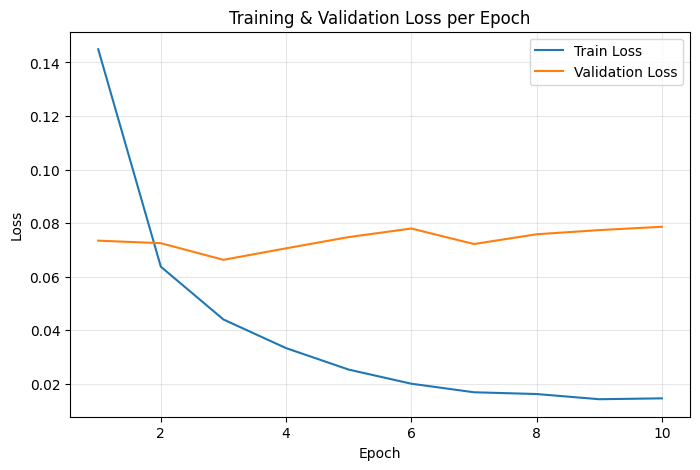

In [23]:
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss per Epoch')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

During training, we observed that the best validation loss was achieved at epoch 3. Therefore, we selected the model from this epoch as our final model for further evaluation and experiments.

In [31]:
model = resnet50(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.fc = nn.Linear(model.fc.in_features, len(label_columns))  # Adjust output layer
model = model.to(device)

for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 3
criterion = nn.BCEWithLogitsLoss()

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


torch.save(model.state_dict(), 'fine_resnet50.pth')
print("Model saved successfully!")

Epoch [1/3], Loss: 0.1456
Validation Loss: 0.0737
Epoch [2/3], Loss: 0.0634
Validation Loss: 0.0642
Epoch [3/3], Loss: 0.0424
Validation Loss: 0.0778
Model saved successfully!


In [77]:

# Predict on test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       0.99      0.98      0.99       237
         bus       0.98      0.97      0.97        92
       cycle       0.98      0.96      0.97       226
      ektara       1.00      0.68      0.81        22
      flutes       0.92      0.81      0.86        42
   harmonium       0.85      0.68      0.75        34
  motorcycle       0.96      0.91      0.93       159
   mountains       0.54      0.52      0.53        29
      person       0.86      0.72      0.79       332
         sea       0.96      0.95      0.95       240
       sitar       0.84      0.79      0.82        34
      sunset       0.62      0.53      0.57        15
       tabla       0.93      0.98      0.96       125
       trees       0.86      0.74      0.79       223
       truck       0.96      0.99      0.97       139

   micro avg       0.93      0.87      0.90      1949
   macro avg       0.88      0.81      0.84      1949
weighted avg       0.92   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### EfficientNet-B0

In [ ]:
model = create_model('efficientnet_b0', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
criterion = nn.BCEWithLogitsLoss()
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Validation Loss: {avg_val_loss:.4f}")


Epoch [1/10], Loss: 0.2796
Validation Loss: 0.1150
Epoch [2/10], Loss: 0.1021
Validation Loss: 0.0830
Epoch [3/10], Loss: 0.0715
Validation Loss: 0.0718
Epoch [4/10], Loss: 0.0534
Validation Loss: 0.0678
Epoch [5/10], Loss: 0.0431
Validation Loss: 0.0669
Epoch [6/10], Loss: 0.0336
Validation Loss: 0.0672
Epoch [7/10], Loss: 0.0296
Validation Loss: 0.0690
Epoch [8/10], Loss: 0.0251
Validation Loss: 0.0748
Epoch [9/10], Loss: 0.0209
Validation Loss: 0.0738
Epoch [10/10], Loss: 0.0186
Validation Loss: 0.0719


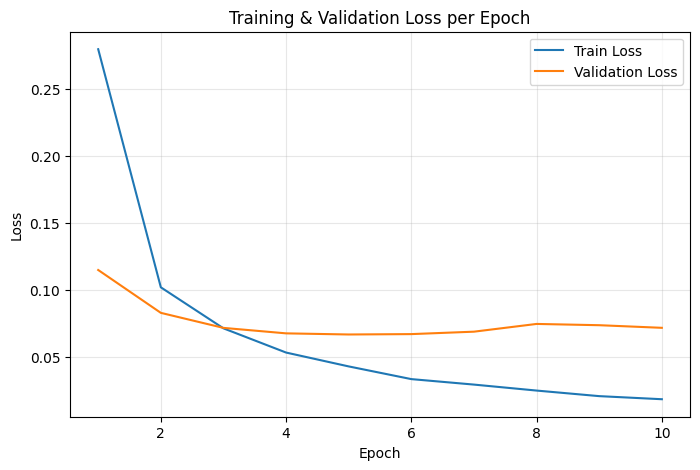

In [28]:
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss per Epoch')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

During training, we observed that the best validation loss was achieved at epoch 5. Therefore, we selected the model from this epoch as our final model for further evaluation and experiments.

In [54]:
model = create_model('efficientnet_b0', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5
criterion = nn.BCEWithLogitsLoss()

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


torch.save(model.state_dict(), 'fine_efficientb0.pth')
print("Model saved successfully!")

Epoch [1/5], Loss: 0.2845
Validation Loss: 0.1206
Epoch [2/5], Loss: 0.1020
Validation Loss: 0.0846
Epoch [3/5], Loss: 0.0737
Validation Loss: 0.0722
Epoch [4/5], Loss: 0.0544
Validation Loss: 0.0672
Epoch [5/5], Loss: 0.0428
Validation Loss: 0.0669
Model saved successfully!


In [ ]:
# Predict on test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       0.99      0.99      0.99       237
         bus       0.92      0.97      0.94        92
       cycle       0.98      0.98      0.98       226
      ektara       0.94      0.77      0.85        22
      flutes       0.85      0.81      0.83        42
   harmonium       0.80      0.82      0.81        34
  motorcycle       0.98      0.92      0.95       159
   mountains       0.33      0.03      0.06        29
      person       0.86      0.82      0.84       332
         sea       0.95      0.95      0.95       240
       sitar       0.81      0.88      0.85        34
      sunset       0.86      0.40      0.55        15
       tabla       0.92      0.97      0.95       125
       trees       0.86      0.83      0.84       223
       truck       0.97      0.95      0.96       139

   micro avg       0.92      0.90      0.91      1949
   macro avg       0.87      0.81      0.82      1949
weighted avg       0.92   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### DenseNet-121

In [ ]:
model = densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
criterion = nn.BCEWithLogitsLoss()
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Validation Loss: {avg_val_loss:.4f}")

Epoch [1/10], Loss: 0.2154
Validation Loss: 0.0952
Epoch [2/10], Loss: 0.0840
Validation Loss: 0.0744
Epoch [3/10], Loss: 0.0591
Validation Loss: 0.0702
Epoch [4/10], Loss: 0.0429
Validation Loss: 0.0672
Epoch [5/10], Loss: 0.0333
Validation Loss: 0.0681
Epoch [6/10], Loss: 0.0279
Validation Loss: 0.0680
Epoch [7/10], Loss: 0.0237
Validation Loss: 0.0666
Epoch [8/10], Loss: 0.0191
Validation Loss: 0.0694
Epoch [9/10], Loss: 0.0175
Validation Loss: 0.0705
Epoch [10/10], Loss: 0.0165
Validation Loss: 0.0719


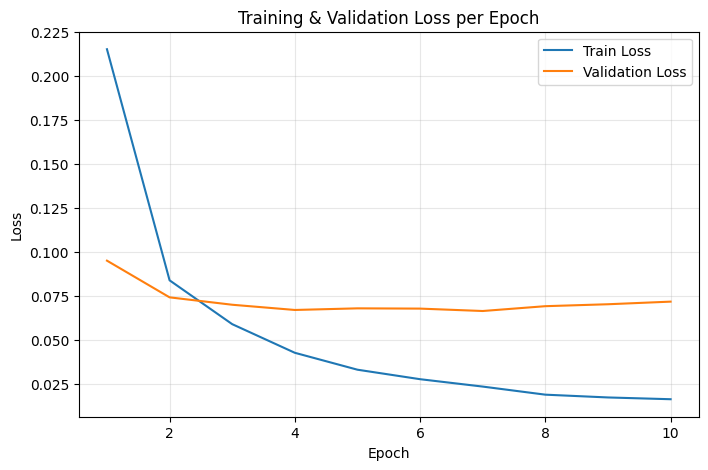

In [37]:
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss per Epoch')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

During training, we observed that the best validation loss was achieved at epoch 4. Therefore, we selected the model from this epoch as our final model for further evaluation and experiments.

In [38]:
model = densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 4
criterion = nn.BCEWithLogitsLoss()

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


torch.save(model.state_dict(), 'fine_densenet121.pth')
print("Model saved successfully!")

Epoch [1/4], Loss: 0.2110
Validation Loss: 0.0937
Epoch [2/4], Loss: 0.0830
Validation Loss: 0.0737
Epoch [3/4], Loss: 0.0585
Validation Loss: 0.0700
Epoch [4/4], Loss: 0.0431
Validation Loss: 0.0666
Model saved successfully!


In [ ]:
# Predict on test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))

              precision    recall  f1-score   support

        boat       1.00      0.97      0.99       237
         bus       1.00      0.97      0.98        92
       cycle       0.98      0.99      0.98       226
      ektara       0.95      0.91      0.93        22
      flutes       0.92      0.79      0.85        42
   harmonium       0.89      0.74      0.81        34
  motorcycle       0.99      0.94      0.96       159
   mountains       0.80      0.41      0.55        29
      person       0.88      0.77      0.82       332
         sea       0.97      0.93      0.95       240
       sitar       0.78      0.85      0.82        34
      sunset       0.80      0.53      0.64        15
       tabla       0.93      0.99      0.96       125
       trees       0.85      0.80      0.82       223
       truck       0.97      0.98      0.97       139

   micro avg       0.94      0.89      0.91      1949
   macro avg       0.91      0.84      0.87      1949
weighted avg       0.94   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### ViT-B/16

In [41]:
model = vit_b_16(pretrained=True)
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
criterion = nn.BCEWithLogitsLoss()
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Validation Loss: {avg_val_loss:.4f}")


Epoch [1/10], Loss: 0.1315
Validation Loss: 0.0731
Epoch [2/10], Loss: 0.0618
Validation Loss: 0.0745
Epoch [3/10], Loss: 0.0432
Validation Loss: 0.0672
Epoch [4/10], Loss: 0.0342
Validation Loss: 0.0691
Epoch [5/10], Loss: 0.0275
Validation Loss: 0.0726
Epoch [6/10], Loss: 0.0264
Validation Loss: 0.0810
Epoch [7/10], Loss: 0.0241
Validation Loss: 0.0727
Epoch [8/10], Loss: 0.0198
Validation Loss: 0.0813
Epoch [9/10], Loss: 0.0240
Validation Loss: 0.0852
Epoch [10/10], Loss: 0.0189
Validation Loss: 0.1077


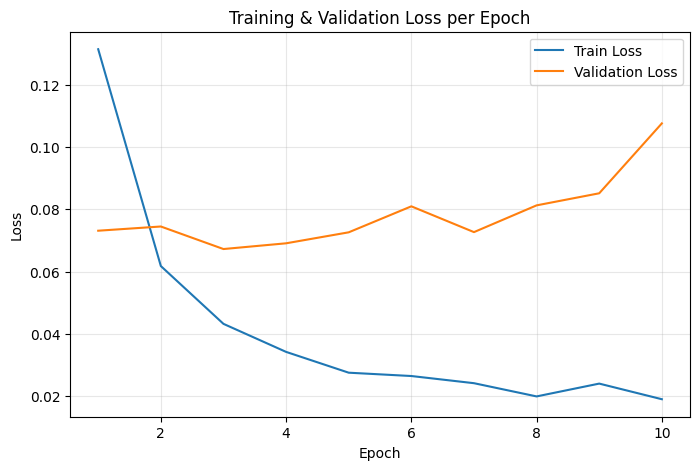

In [43]:
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss per Epoch')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

During training, we observed that the best validation loss was achieved at epoch 3. Therefore, we selected the model from this epoch as our final model for further evaluation and experiments.

In [44]:
model = vit_b_16(pretrained=True)
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 3
criterion = nn.BCEWithLogitsLoss()

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


torch.save(model.state_dict(), 'fine_vit.pth')
print("Model saved successfully!")

Epoch [1/3], Loss: 0.0919
Validation Loss: 0.0880
Epoch [2/3], Loss: 0.0582
Validation Loss: 0.0608
Epoch [3/3], Loss: 0.0401
Validation Loss: 0.0652
Model saved successfully!


In [83]:
# Predict on test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       0.99      0.99      0.99       237
         bus       0.87      0.98      0.92        92
       cycle       1.00      0.96      0.98       226
      ektara       0.95      0.91      0.93        22
      flutes       0.87      0.79      0.82        42
   harmonium       0.80      0.71      0.75        34
  motorcycle       0.99      0.95      0.97       159
   mountains       0.60      0.41      0.49        29
      person       0.82      0.82      0.82       332
         sea       0.96      0.95      0.95       240
       sitar       0.86      0.88      0.87        34
      sunset       1.00      0.40      0.57        15
       tabla       0.94      0.95      0.95       125
       trees       0.78      0.85      0.81       223
       truck       0.99      0.83      0.91       139

   micro avg       0.91      0.89      0.90      1949
   macro avg       0.90      0.83      0.85      1949
weighted avg       0.91   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### DeiT-base/16

In [48]:
model = create_model('deit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
criterion = nn.BCEWithLogitsLoss()
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Validation Loss: {avg_val_loss:.4f}")

Epoch [1/10], Loss: 0.1171
Validation Loss: 0.0706
Epoch [2/10], Loss: 0.0465
Validation Loss: 0.0610
Epoch [3/10], Loss: 0.0286
Validation Loss: 0.0554
Epoch [4/10], Loss: 0.0206
Validation Loss: 0.0587
Epoch [5/10], Loss: 0.0149
Validation Loss: 0.0620
Epoch [6/10], Loss: 0.0127
Validation Loss: 0.0634
Epoch [7/10], Loss: 0.0113
Validation Loss: 0.0657
Epoch [8/10], Loss: 0.0100
Validation Loss: 0.0659
Epoch [9/10], Loss: 0.0091
Validation Loss: 0.0675
Epoch [10/10], Loss: 0.0091
Validation Loss: 0.0872


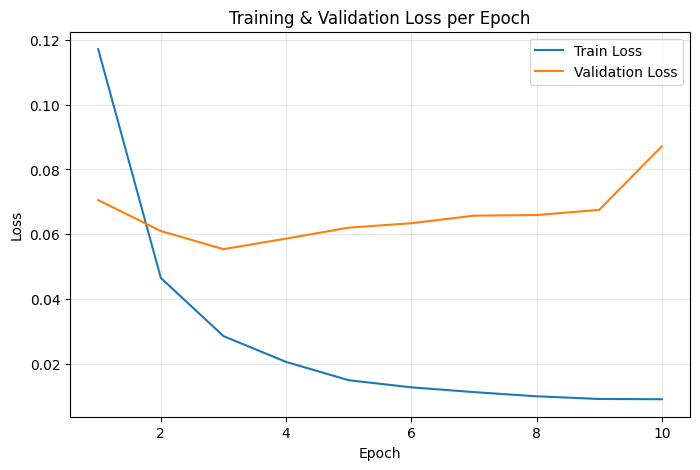

In [50]:
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss per Epoch')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

During training, we observed that the best validation loss was achieved at epoch 3. Therefore, we selected the model from this epoch as our final model for further evaluation and experiments.

In [51]:
model = create_model('deit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 3
criterion = nn.BCEWithLogitsLoss()

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


torch.save(model.state_dict(), 'fine_deit.pth')
print("Model saved successfully!")

Epoch [1/3], Loss: 0.1003
Validation Loss: 0.0648
Epoch [2/3], Loss: 0.0462
Validation Loss: 0.0566
Epoch [3/3], Loss: 0.0274
Validation Loss: 0.0559
Model saved successfully!


In [85]:

# Predict on test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       1.00      1.00      1.00       237
         bus       0.99      0.98      0.98        92
       cycle       0.99      0.98      0.99       226
      ektara       0.95      0.86      0.90        22
      flutes       0.89      0.79      0.84        42
   harmonium       0.84      0.79      0.82        34
  motorcycle       1.00      0.94      0.97       159
   mountains       0.68      0.59      0.63        29
      person       0.86      0.80      0.83       332
         sea       0.97      0.94      0.95       240
       sitar       0.88      0.85      0.87        34
      sunset       1.00      0.47      0.64        15
       tabla       0.98      0.95      0.96       125
       trees       0.79      0.88      0.83       223
       truck       0.98      0.99      0.98       139

   micro avg       0.93      0.91      0.92      1949
   macro avg       0.92      0.85      0.88      1949
weighted avg       0.93   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Ensemble Model (Average)

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(label_columns) 

# Load ResNet
resnet = resnet50(pretrained=False)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
resnet.load_state_dict(torch.load('fine_resnet50.pth'))
resnet.to(device)
resnet.eval()

# Load DenseNet
densenet = densenet121(pretrained=False)
densenet.classifier = torch.nn.Linear(densenet.classifier.in_features, num_classes)
densenet.load_state_dict(torch.load('fine_densenet121.pth'))
densenet.to(device)
densenet.eval()

# Load EfficientNet
efficientnet = create_model('efficientnet_b0', pretrained=False, num_classes=num_classes)
efficientnet.load_state_dict(torch.load('fine_efficientb0.pth'))
efficientnet.to(device)
efficientnet.eval()

# Load ViT
vit = vit_b_16(pretrained=False)  # no need pretrained, since you are loading your weights
vit.heads.head = torch.nn.Linear(vit.heads.head.in_features, num_classes)
vit.load_state_dict(torch.load('fine_vit.pth'))
vit.to(device)
vit.eval()

# Load DeiT
deit = create_model('deit_base_patch16_224', pretrained=False, num_classes=num_classes)
deit.load_state_dict(torch.load('fine_deit.pth'))
deit.to(device)
deit.eval()


/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_3060344/1897199636.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `w

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [87]:
models = [resnet, densenet, efficientnet, vit, deit]


def ensemble_predict(models, images):
    outputs = []
    for model in models:
        with torch.no_grad():
            out = model(images)
            outputs.append(torch.sigmoid(out))  # Apply sigmoid for multi-label

    outputs = torch.stack(outputs, dim=0)  # (num_models, batch_size, num_classes)
    outputs = outputs.mean(dim=0)           # Average over models
    return outputs

all_labels = []
all_predictions = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    # Ensemble prediction
    outputs = ensemble_predict(models, images)

    predictions = (outputs > 0.5).float()  # Apply 0.5 threshold

    all_labels.append(labels.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

# Stack all the results
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Print classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))



              precision    recall  f1-score   support

        boat       1.00      1.00      1.00       237
         bus       0.98      0.97      0.97        92
       cycle       0.99      0.98      0.98       226
      ektara       0.95      0.91      0.93        22
      flutes       0.89      0.81      0.85        42
   harmonium       0.84      0.79      0.82        34
  motorcycle       1.00      0.94      0.97       159
   mountains       0.69      0.38      0.49        29
      person       0.88      0.79      0.83       332
         sea       0.96      0.95      0.95       240
       sitar       0.83      0.85      0.84        34
      sunset       1.00      0.53      0.70        15
       tabla       0.94      0.98      0.96       125
       trees       0.86      0.83      0.84       223
       truck       0.97      0.98      0.97       139

   micro avg       0.94      0.90      0.92      1949
   macro avg       0.92      0.85      0.87      1949
weighted avg       0.94   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Strategy II: Gradual Layer-Wise Fine-Tuning

- **Initial Freezing:**  
  - At the start, **all layers** of the ResNet50 model are frozen (`requires_grad = False`). This prevents their weights from being updated during training.
  - Only the final classification head (`fc`) and the last residual block (`layer4`) are unfrozen and trained initially. This focuses learning on the most task-specific layers, reducing overfitting and speeding up convergence.

- **Gradual Unfreezing:**  
  - At epoch 3, the previous block (`layer3`) is also unfrozen, allowing its weights to be updated for the remaining epochs.
  - The optimizer is updated at this point to include the new trainable parameters, and a lower learning rate (`1e-5`) is used to avoid disrupting previously learned weights.

- **Training Approach:**  
  - For the first few epochs, only a small subset of layers is trained, leveraging powerful pre-trained features in the early layers.
  - As training progresses, more of the network is fine-tuned, allowing deeper adaptation to the new dataset without immediately overfitting or destabilizing the model.

**Layer-wise fine-tuning** helps stabilize training and allows the model to adapt gradually, starting with the most relevant (higher) layers and progressively learning more specific features from the new data.

#### ResNet50

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet50
model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(label_columns))
model = model.to(device)

# ----------------- Freeze all layers initially -----------------
for param in model.parameters():
    param.requires_grad = False

# ----------------- Unfreeze classifier and last block (layer4) -----------------
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# ----------------- Optimizer: only trainable params -----------------
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# ----------------- Loss -----------------
criterion = nn.BCEWithLogitsLoss()

num_epochs = 5

for epoch in range(num_epochs):
    # ----------------- Gradual unfreezing at epoch 3 -----------------
    if epoch == 3:
        print("Unfreezing layer3 for training...")
        for param in model.layer3.parameters():
            param.requires_grad = True
        # Update optimizer to include new parameters
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # ----------------- Validation -----------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")

# Save model
torch.save(model.state_dict(), 'fine_grad_resnet50.pth')
print("Model saved successfully!")


/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 0.1477
Validation Loss: 0.0742
Epoch [2/5], Loss: 0.0647
Validation Loss: 0.0676
Epoch [3/5], Loss: 0.0435
Validation Loss: 0.0651
Unfreezing layer3 for training...
Epoch [4/5], Loss: 0.0277
Validation Loss: 0.0625
Epoch [5/5], Loss: 0.0229
Validation Loss: 0.0627
Model saved successfully!


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet50
model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(label_columns))
model = model.to(device)

# ----------------- Freeze all layers initially -----------------
for param in model.parameters():
    param.requires_grad = False

# ----------------- Unfreeze classifier and last block (layer4) -----------------
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# ----------------- Optimizer: only trainable params -----------------
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# ----------------- Loss -----------------
criterion = nn.BCEWithLogitsLoss()

num_epochs = 4

for epoch in range(num_epochs):
    # ----------------- Gradual unfreezing at epoch 3 -----------------
    if epoch == 3:
        print("Unfreezing layer3 for training...")
        for param in model.layer3.parameters():
            param.requires_grad = True
        # Update optimizer to include new parameters
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # ----------------- Validation -----------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")

# Save model
torch.save(model.state_dict(), 'fine_grad_resnet50.pth')
print("Model saved successfully!")


/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/4], Loss: 0.1475
Validation Loss: 0.0730
Epoch [2/4], Loss: 0.0646
Validation Loss: 0.0663
Epoch [3/4], Loss: 0.0434
Validation Loss: 0.0660
Unfreezing layer3 for training...
Epoch [4/4], Loss: 0.0279
Validation Loss: 0.0606
Model saved successfully!


In [ ]:
# Predict on test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       1.00      0.99      0.99       237
         bus       0.98      0.97      0.97        92
       cycle       0.99      0.96      0.97       226
      ektara       0.95      0.91      0.93        22
      flutes       0.89      0.81      0.85        42
   harmonium       0.84      0.76      0.80        34
  motorcycle       0.98      0.93      0.95       159
   mountains       0.80      0.55      0.65        29
      person       0.88      0.77      0.82       332
         sea       0.96      0.95      0.95       240
       sitar       0.88      0.85      0.87        34
      sunset       0.83      0.67      0.74        15
       tabla       0.95      0.98      0.96       125
       trees       0.83      0.81      0.82       223
       truck       0.97      0.99      0.98       139

   micro avg       0.94      0.89      0.92      1949
   macro avg       0.92      0.86      0.88      1949
weighted avg       0.93   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### EfficientNet-B0

Epoch [1/10], Train Loss: 0.3145
Validation Loss: 0.1416
Epoch [2/10], Train Loss: 0.1249
Validation Loss: 0.0959
Epoch [3/10], Train Loss: 0.0896
Validation Loss: 0.0824
Epoch [4/10], Train Loss: 0.0717
Validation Loss: 0.0725
Epoch [5/10], Train Loss: 0.0577
Validation Loss: 0.0710
Unfreezing more blocks for training...
Epoch [6/10], Train Loss: 0.0478
Validation Loss: 0.0693
Epoch [7/10], Train Loss: 0.0464
Validation Loss: 0.0687
Epoch [8/10], Train Loss: 0.0451
Validation Loss: 0.0688
Epoch [9/10], Train Loss: 0.0432
Validation Loss: 0.0676
Epoch [10/10], Train Loss: 0.0413
Validation Loss: 0.0675
Model saved successfully!


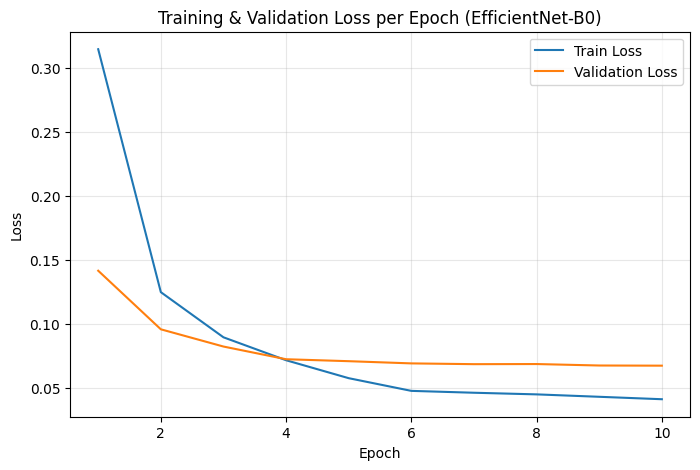

In [ ]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build model
model = create_model('efficientnet_b0', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(device)

# ------------- Freeze all layers -------------
for param in model.parameters():
    param.requires_grad = False

# ------------- Unfreeze classifier and last block(s) -------------
for param in model.classifier.parameters():
    param.requires_grad = True

# Unfreeze last 2 blocks (can adjust number)
for param in model.blocks[-2:].parameters():
    param.requires_grad = True

# ------------- Optimizer (trainable params only) -------------
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # -------- Gradual unfreezing at epoch 5 (example) --------
    if epoch == 5:
        print("Unfreezing more blocks for training...")
        for param in model.blocks[-4:].parameters():  # Unfreeze more, e.g., last 4 blocks
            param.requires_grad = True
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # -------- Validation --------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss:.4f}")

# Save model
torch.save(model.state_dict(), 'fine_grad_efficientnetb0.pth')
print("Model saved successfully!")

# -------- Plot Loss Curves --------
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss per Epoch (EfficientNet-B0)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# Predict on test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))

              precision    recall  f1-score   support

        boat       1.00      0.99      0.99       237
         bus       0.92      0.98      0.95        92
       cycle       0.97      0.98      0.97       226
      ektara       0.83      0.68      0.75        22
      flutes       0.88      0.83      0.85        42
   harmonium       0.85      0.82      0.84        34
  motorcycle       0.97      0.90      0.93       159
   mountains       0.00      0.00      0.00        29
      person       0.88      0.80      0.83       332
         sea       0.95      0.93      0.94       240
       sitar       0.83      0.85      0.84        34
      sunset       1.00      0.20      0.33        15
       tabla       0.93      0.99      0.96       125
       trees       0.86      0.80      0.83       223
       truck       0.97      0.92      0.94       139

   micro avg       0.93      0.88      0.90      1949
   macro avg       0.86      0.78      0.80      1949
weighted avg       0.92   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### DenseNet-121

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] Train Loss: 0.2284
Epoch [1/10] Val   Loss: 0.1128
Epoch [2/10] Train Loss: 0.1045
Epoch [2/10] Val   Loss: 0.0870
Epoch [3/10] Train Loss: 0.0811
Epoch [3/10] Val   Loss: 0.0769
Epoch [4/10] Train Loss: 0.0686
Epoch [4/10] Val   Loss: 0.0722
Epoch [5/10] Train Loss: 0.0580
Epoch [5/10] Val   Loss: 0.0688
Unfreezing denseblock3 for training...
Epoch [6/10] Train Loss: 0.0483
Epoch [6/10] Val   Loss: 0.0680
Epoch [7/10] Train Loss: 0.0451
Epoch [7/10] Val   Loss: 0.0666
Epoch [8/10] Train Loss: 0.0435
Epoch [8/10] Val   Loss: 0.0667
Epoch [9/10] Train Loss: 0.0402
Epoch [9/10] Val   Loss: 0.0668
Epoch [10/10] Train Loss: 0.0376
Epoch [10/10] Val   Loss: 0.0656
Model saved successfully!


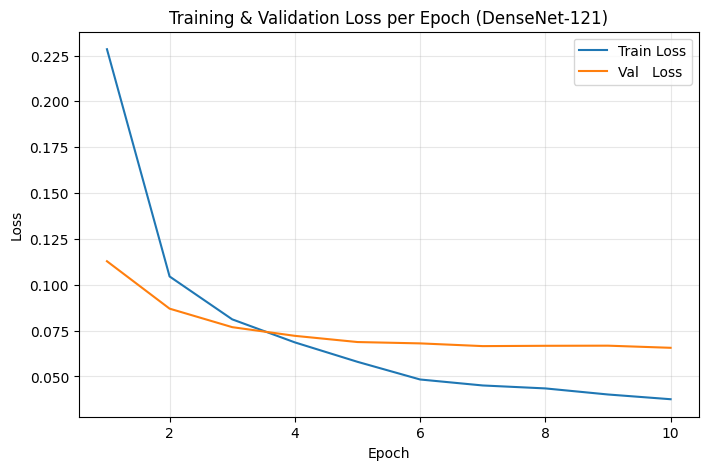

In [ ]:
# ----------------- Setup -----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------- Build DenseNet121 -----------------
model = densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(device)

# ----------------- Freeze everything -----------------
for param in model.parameters():
    param.requires_grad = False

# ----------------- Unfreeze classifier and last dense block -----------------
for param in model.features.denseblock4.parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

# ----------------- Optimizer & Loss -----------------
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)
criterion = nn.BCEWithLogitsLoss()

# ----------------- Training loop with gradual unfreeze -----------------
num_epochs   = 10
train_losses = []
val_losses   = []

for epoch in range(num_epochs):
    # Gradual unfreezing at epoch 5
    if epoch == 5:
        print("Unfreezing denseblock3 for training...")
        for param in model.features.denseblock3.parameters():
            param.requires_grad = True
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=1e-5
        )

    # —— Training Phase ——  
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train = running_loss / len(train_loader)
    train_losses.append(avg_train)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train:.4f}")

    # —— Validation Phase ——  
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val = val_loss / len(val_loader)
    val_losses.append(avg_val)
    print(f"Epoch [{epoch+1}/{num_epochs}] Val   Loss: {avg_val:.4f}")

# ----------------- Save -----------------
torch.save(model.state_dict(), 'fine_grad_densenet121.pth')
print("Model saved successfully!")

# ----------------- Plot Loss Curves -----------------
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses,   label='Val   Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss per Epoch (DenseNet-121)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [98]:
# Predict on test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       1.00      0.99      0.99       237
         bus       0.98      0.98      0.98        92
       cycle       0.98      0.97      0.98       226
      ektara       0.94      0.77      0.85        22
      flutes       0.87      0.79      0.82        42
   harmonium       0.93      0.79      0.86        34
  motorcycle       0.99      0.92      0.95       159
   mountains       1.00      0.21      0.34        29
      person       0.87      0.80      0.84       332
         sea       0.95      0.95      0.95       240
       sitar       0.90      0.82      0.86        34
      sunset       0.88      0.47      0.61        15
       tabla       0.94      0.98      0.96       125
       trees       0.84      0.80      0.82       223
       truck       0.98      0.98      0.98       139

   micro avg       0.94      0.89      0.91      1949
   macro avg       0.94      0.81      0.85      1949
weighted avg       0.94   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### ViT-B/16

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] Train Loss: 0.1489
Epoch [1/10] Val   Loss: 0.0829
Epoch [2/10] Train Loss: 0.0685
Epoch [2/10] Val   Loss: 0.0661
Epoch [3/10] Train Loss: 0.0499
Epoch [3/10] Val   Loss: 0.0612
Epoch [4/10] Train Loss: 0.0370
Epoch [4/10] Val   Loss: 0.0604
Epoch [5/10] Train Loss: 0.0279
Epoch [5/10] Val   Loss: 0.0648
Unfreezing more transformer blocks...
Epoch [6/10] Train Loss: 0.0184
Epoch [6/10] Val   Loss: 0.0605
Epoch [7/10] Train Loss: 0.0158
Epoch [7/10] Val   Loss: 0.0619
Epoch [8/10] Train Loss: 0.0148
Epoch [8/10] Val   Loss: 0.0622
Epoch [9/10] Train Loss: 0.0136
Epoch [9/10] Val   Loss: 0.0650
Epoch [10/10] Train Loss: 0.0129
Epoch [10/10] Val   Loss: 0.0638
Model saved successfully!


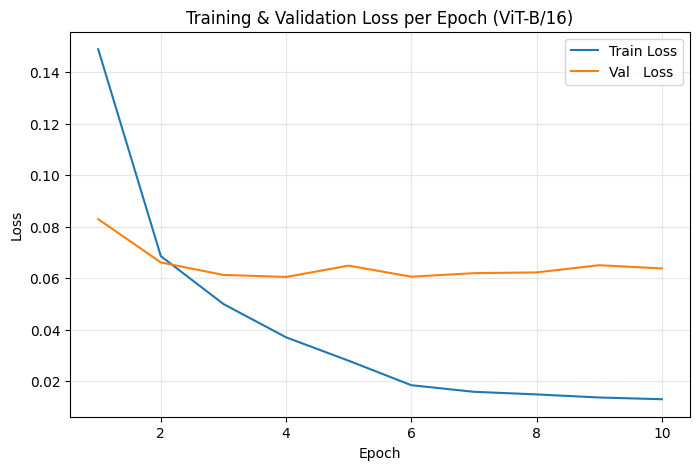

In [95]:
# ----------------- Setup -----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------- Build ViT model -----------------
model = vit_b_16(pretrained=True)
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
model = model.to(device)

# ----------------- Freeze everything -----------------
for param in model.parameters():
    param.requires_grad = False

# ----------------- Unfreeze classifier and last 2 transformer blocks -----------------
for param in model.heads.head.parameters():
    param.requires_grad = True

# torchvision ViT stores its blocks in model.encoder.layers
for block in model.encoder.layers[-2:]:
    for param in block.parameters():
        param.requires_grad = True

# ----------------- Optimizer & Loss -----------------
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-4
)
criterion = nn.BCEWithLogitsLoss()

# ----------------- Training with gradual unfreeze -----------------
num_epochs   = 10
train_losses = []
val_losses   = []

for epoch in range(num_epochs):
    # at epoch 5, unfreeze more blocks (e.g. last 4)
    if epoch == 5:
        print("Unfreezing more transformer blocks...")
        for block in model.encoder.layers[-4:]:
            for param in block.parameters():
                param.requires_grad = True
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()), 
            lr=1e-5
        )

    # —— Training Phase ——  
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train = running_loss / len(train_loader)
    train_losses.append(avg_train)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train:.4f}")

    # —— Validation Phase ——  
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val = val_loss / len(val_loader)
    val_losses.append(avg_val)
    print(f"Epoch [{epoch+1}/{num_epochs}] Val   Loss: {avg_val:.4f}")

# ----------------- Save -----------------
torch.save(model.state_dict(), 'fine_grad_vit_b_16.pth')
print("Model saved successfully!")

# ----------------- Plot Loss Curves -----------------
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses,   label='Val   Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss per Epoch (ViT-B/16)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [96]:
# Predict on test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       1.00      1.00      1.00       237
         bus       0.97      0.95      0.96        92
       cycle       0.97      0.97      0.97       226
      ektara       0.95      0.91      0.93        22
      flutes       0.85      0.83      0.84        42
   harmonium       0.79      0.79      0.79        34
  motorcycle       0.99      0.94      0.96       159
   mountains       0.82      0.48      0.61        29
      person       0.87      0.83      0.85       332
         sea       0.95      0.95      0.95       240
       sitar       0.84      0.79      0.82        34
      sunset       1.00      0.33      0.50        15
       tabla       0.94      0.98      0.96       125
       trees       0.84      0.70      0.76       223
       truck       0.97      0.99      0.98       139

   micro avg       0.93      0.89      0.91      1949
   macro avg       0.92      0.83      0.86      1949
weighted avg       0.93   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### DeiT-base/16

Epoch [1/10] Train Loss: 0.1554
Epoch [1/10] Val   Loss: 0.0712
Epoch [2/10] Train Loss: 0.0589
Epoch [2/10] Val   Loss: 0.0569
Epoch [3/10] Train Loss: 0.0401
Epoch [3/10] Val   Loss: 0.0522
Epoch [4/10] Train Loss: 0.0268
Epoch [4/10] Val   Loss: 0.0522
Epoch [5/10] Train Loss: 0.0192
Epoch [5/10] Val   Loss: 0.0570
Unfreezing more transformer blocks...
Epoch [6/10] Train Loss: 0.0128
Epoch [6/10] Val   Loss: 0.0550
Epoch [7/10] Train Loss: 0.0110
Epoch [7/10] Val   Loss: 0.0547
Epoch [8/10] Train Loss: 0.0103
Epoch [8/10] Val   Loss: 0.0554
Epoch [9/10] Train Loss: 0.0096
Epoch [9/10] Val   Loss: 0.0559
Epoch [10/10] Train Loss: 0.0092
Epoch [10/10] Val   Loss: 0.0569
Model saved successfully!


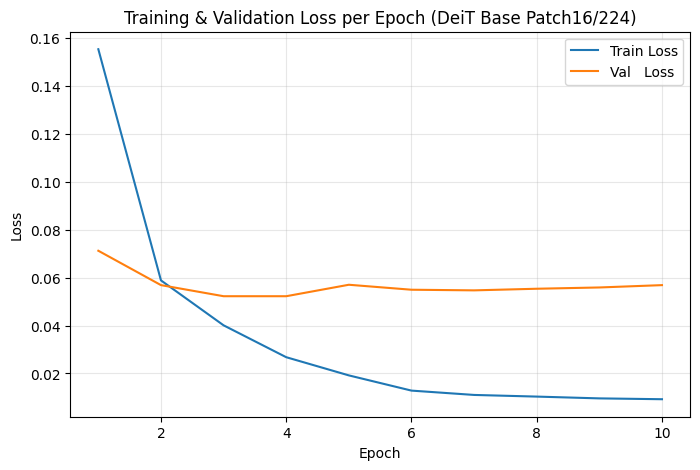

In [ ]:
# ----------------- Setup -----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------- Build DeiT model -----------------
model = create_model('deit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)

# ----------------- Freeze all layers -----------------
for param in model.parameters():
    param.requires_grad = False

# ----------------- Unfreeze classifier head and last 2 transformer blocks -----------------
for param in model.head.parameters():
    param.requires_grad = True

# timm DeiT stores transformer blocks in model.blocks
for block in model.blocks[-2:]:
    for param in block.parameters():
        param.requires_grad = True

# ----------------- Optimizer & Loss -----------------
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)
criterion = nn.BCEWithLogitsLoss()

# ----------------- Training with gradual unfreeze -----------------
num_epochs   = 10
train_losses = []
val_losses   = []

for epoch in range(num_epochs):
    # Gradual unfreezing at epoch 5
    if epoch == 5:
        print("Unfreezing more transformer blocks...")
        for block in model.blocks[-4:]:   # now unfreeze last 4 blocks
            for param in block.parameters():
                param.requires_grad = True
        # lower LR and update optimizer
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=1e-5
        )

    # —— Training Phase ——
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train = running_loss / len(train_loader)
    train_losses.append(avg_train)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train:.4f}")

    # —— Validation Phase ——
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val = val_loss / len(val_loader)
    val_losses.append(avg_val)
    print(f"Epoch [{epoch+1}/{num_epochs}] Val   Loss: {avg_val:.4f}")

# ----------------- Save the fine-tuned model -----------------
torch.save(model.state_dict(), 'fine_grad_deit_base_patch16_224.pth')
print("Model saved successfully!")

# ----------------- Plot Loss Curves -----------------
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses,   label='Val   Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss per Epoch (DeiT Base Patch16/224)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [100]:
# Predict on test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       1.00      1.00      1.00       237
         bus       1.00      0.99      0.99        92
       cycle       0.99      0.99      0.99       226
      ektara       0.95      0.86      0.90        22
      flutes       0.85      0.79      0.81        42
   harmonium       0.79      0.79      0.79        34
  motorcycle       1.00      0.95      0.97       159
   mountains       0.84      0.55      0.67        29
      person       0.88      0.83      0.85       332
         sea       0.97      0.95      0.96       240
       sitar       0.83      0.85      0.84        34
      sunset       0.83      0.33      0.48        15
       tabla       0.93      0.97      0.95       125
       trees       0.87      0.77      0.82       223
       truck       0.99      0.99      0.99       139

   micro avg       0.94      0.91      0.92      1949
   macro avg       0.91      0.84      0.87      1949
weighted avg       0.94   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Ensemble Model (Average)

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(label_columns) 

# Load ResNet
resnet = resnet50(pretrained=False)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
resnet.load_state_dict(torch.load('fine_grad_resnet50.pth'))
resnet.to(device)
resnet.eval()

# Load DenseNet
densenet = densenet121(pretrained=False)
densenet.classifier = torch.nn.Linear(densenet.classifier.in_features, num_classes)
densenet.load_state_dict(torch.load('fine_grad_densenet121.pth'))
densenet.to(device)
densenet.eval()

# Load EfficientNet
efficientnet = create_model('efficientnet_b0', pretrained=False, num_classes=num_classes)
efficientnet.load_state_dict(torch.load('fine_grad_efficientnetb0.pth'))
efficientnet.to(device)
efficientnet.eval()

# Load ViT
vit = vit_b_16(pretrained=False)  # no need pretrained, since you are loading your weights
vit.heads.head = torch.nn.Linear(vit.heads.head.in_features, num_classes)
vit.load_state_dict(torch.load('fine_grad_vit_b_16.pth'))
vit.to(device)
vit.eval()

# Load DeiT
deit = create_model('deit_base_patch16_224', pretrained=False, num_classes=num_classes)
deit.load_state_dict(torch.load('fine_grad_deit_base_patch16_224.pth'))
deit.to(device)
deit.eval()


/tmp/ipykernel_3060344/121875028.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load('fine_grad_resnet50.pth'))
/tmp/ipykernel_3060344/1218

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [104]:
models = [resnet, densenet, efficientnet, vit, deit]

def ensemble_predict(models, images):
    outputs = []
    for model in models:
        with torch.no_grad():
            out = model(images)
            outputs.append(torch.sigmoid(out))  # Apply sigmoid for multi-label

    outputs = torch.stack(outputs, dim=0)  # (num_models, batch_size, num_classes)
    outputs = outputs.mean(dim=0)           # Average over models
    return outputs
all_labels = []
all_predictions = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    # Ensemble prediction
    outputs = ensemble_predict(models, images)

    predictions = (outputs > 0.5).float()  # Apply 0.5 threshold

    all_labels.append(labels.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

# Stack all the results
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Print classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       1.00      1.00      1.00       237
         bus       0.99      0.98      0.98        92
       cycle       0.98      0.99      0.98       226
      ektara       0.95      0.91      0.93        22
      flutes       0.89      0.81      0.85        42
   harmonium       0.84      0.79      0.82        34
  motorcycle       1.00      0.93      0.96       159
   mountains       1.00      0.41      0.59        29
      person       0.90      0.81      0.85       332
         sea       0.96      0.94      0.95       240
       sitar       0.86      0.88      0.87        34
      sunset       1.00      0.33      0.50        15
       tabla       0.93      0.99      0.96       125
       trees       0.88      0.78      0.83       223
       truck       0.98      0.98      0.98       139

   micro avg       0.95      0.90      0.92      1949
   macro avg       0.95      0.84      0.87      1949
weighted avg       0.95   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Explainability: Visualizing Predictions Using Grad-CAM

This part demonstrates how to visualize the predictions of a Convolutional Neural Network (CNN) using **Grad-CAM (Gradient-weighted Class Activation Mapping)** — a powerful method for explaining image classification models.

**Goal**:

- Load a pretrained CNN (ResNet-50).
- Run inference on a sample image from a labeled dataset.
- Apply Grad-CAM to generate a heatmap highlighting regions important for the model's prediction.
- Overlay the heatmap on the original image for explainability.

---

**What is Grad-CAM?**

**Grad-CAM** (Selvaraju et al., 2017) is a model explainability technique for CNNs. It works as follows:

1. **Gradient Calculation**: Computes the gradients of the predicted class score with respect to feature maps of a selected convolutional layer.
2. **Weighting**: Averages the gradients spatially to obtain weights that reflect the importance of each feature map.
3. **Heatmap Generation**: Combines these weights with the corresponding activations and applies a ReLU to retain only positive contributions.
4. **Visualization**: The resulting heatmap highlights image regions most relevant to the prediction.

### Example Application: Grad-CAM with ResNet-50

Columns: ['Image Name', 'Labels', 'boat', 'bus', 'cycle', 'ektara', 'flutes', 'harmonium', 'motorcycle', 'mountains', 'person', 'sea', 'sitar', 'sunset', 'tabla', 'trees', 'truck', 'full_path']
Image Path: /home/annachatz/Deep Learning/multilabel_modified/images/image201.jpg
Ground Truth Labels: ['tabla']


/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_2936302/2609333956.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pyto

Model's top prediction: tabla (Confidence: 1.00)


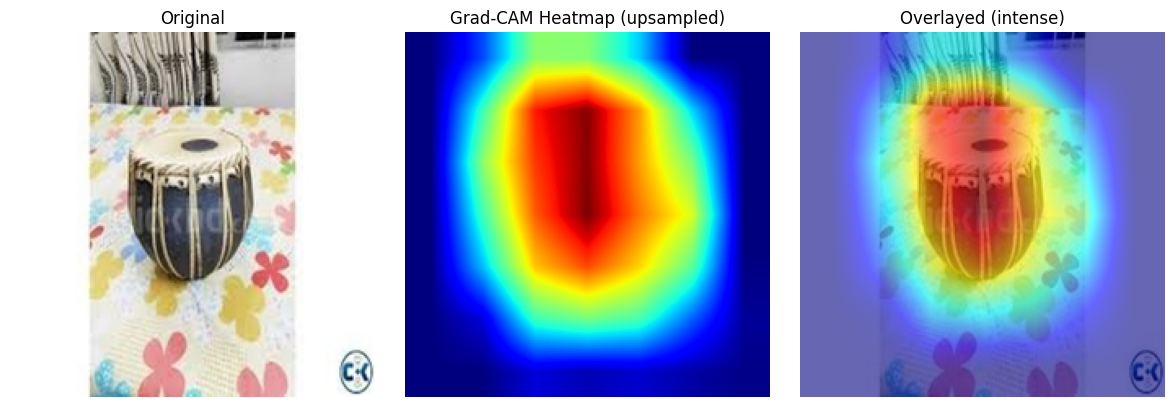

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Detect the filename column robustly ---
print("Columns:", df.columns.tolist())
filename_col = None
for option in ["Image Name", "Image", "filename", "image_name", "img_name"]:
    if option in df.columns:
        filename_col = option
        break
if filename_col is None:
    raise ValueError("Could not find the filename column in your DataFrame.")

# --- Select a random image ---
row = df.iloc[200]  # Or: df.iloc[10]
img_name = row[filename_col]
img_path = images_folder + img_name

print("Image Path:", img_path)
print("Ground Truth Labels:", row['Labels'] if 'Labels' in row else 'Unknown')

# --- Load and preprocess image ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)

# --- Load your model here if not loaded already ---
from torchvision.models import resnet50
model = resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("resnet50.pth"))
model = model.to(device)

# --- Run model to get predictions ---
model.eval()
with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.sigmoid(outputs)[0].cpu().numpy()

# --- Find the most confident label (or pick one) ---
label_columns = [col for col in df.columns if col not in [filename_col, 'Labels', 'full_path']]
target_class_idx = int(np.argmax(probs))
print(f"Model's top prediction: {label_columns[target_class_idx]} (Confidence: {probs[target_class_idx]:.2f})")

# --- Grad-CAM class ---
class GradCAM_mine:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_full_backward_hook(backward_hook))
    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()
    def __call__(self, image_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(image_tensor)
        loss = output[0, class_idx]
        loss.backward()
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]
        heatmap = activations.sum(dim=0).cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= heatmap.max() if heatmap.max() != 0 else 1
        return heatmap.numpy()

# --- Run Grad-CAM ---
grad_cam = GradCAM_mine(model, model.layer4[-1])
_ = model(input_tensor)  # Forward pass
heatmap = grad_cam(input_tensor, class_idx=target_class_idx)
grad_cam.remove_hooks()

# --- Upsample heatmap BEFORE overlaying ---
img = np.array(image.resize((224, 224)))
if img.ndim == 2:
    img = np.stack([img]*3, axis=-1)
if img.shape[2] == 4:
    img = img[:, :, :3]
if img.dtype != np.uint8:
    img = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)

# Resize heatmap to match the image size before applying colormap
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# 1) Amplify contrast of the raw heatmap:
heatmap_amp = np.power(heatmap_resized, 1.5)  # values in [0,1], >1 sharpens

# 2) Create the BGR colormap, then convert to RGB
heatmap_bgr = cv2.applyColorMap(
    np.uint8(255 * heatmap_amp),
    cv2.COLORMAP_JET
)
heatmap_rgb = cv2.cvtColor(heatmap_bgr, cv2.COLOR_BGR2RGB)

# 3) Blend: give the heatmap more weight
image_weight = 0.4   # less of the original image
heatmap_weight = 0.6 # more of the heatmap
overlayed = cv2.addWeighted(img, image_weight, heatmap_rgb, heatmap_weight, 0)

# --- Plot results ---
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img)
plt.axis("off")
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(heatmap_resized, cmap='jet')
plt.axis("off")
plt.title("Grad-CAM Heatmap (upsampled)")

plt.subplot(1,3,3)
plt.imshow(overlayed)
plt.axis("off")
plt.title(f"Overlayed (intense)")

plt.tight_layout()
plt.show()

In [71]:
from torchvision.models import resnet50
model = resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("fine_grad_resnet50.pth"))
model = model.to(device)

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_2936302/3302564477.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytor

This section randomly samples up to 10 images from the dataset to visualize model predictions using Grad-CAM. For each image, it performs preprocessing, runs inference with the trained ResNet-50 model, and identifies predicted labels with confidence above 0.5. Grad-CAM is applied using the most confident class to generate a heatmap, which is then overlaid on the original image. The results are displayed in a grid, with each image titled by its ground truth and predicted labels, making it easier to qualitatively assess model performance and explainability.

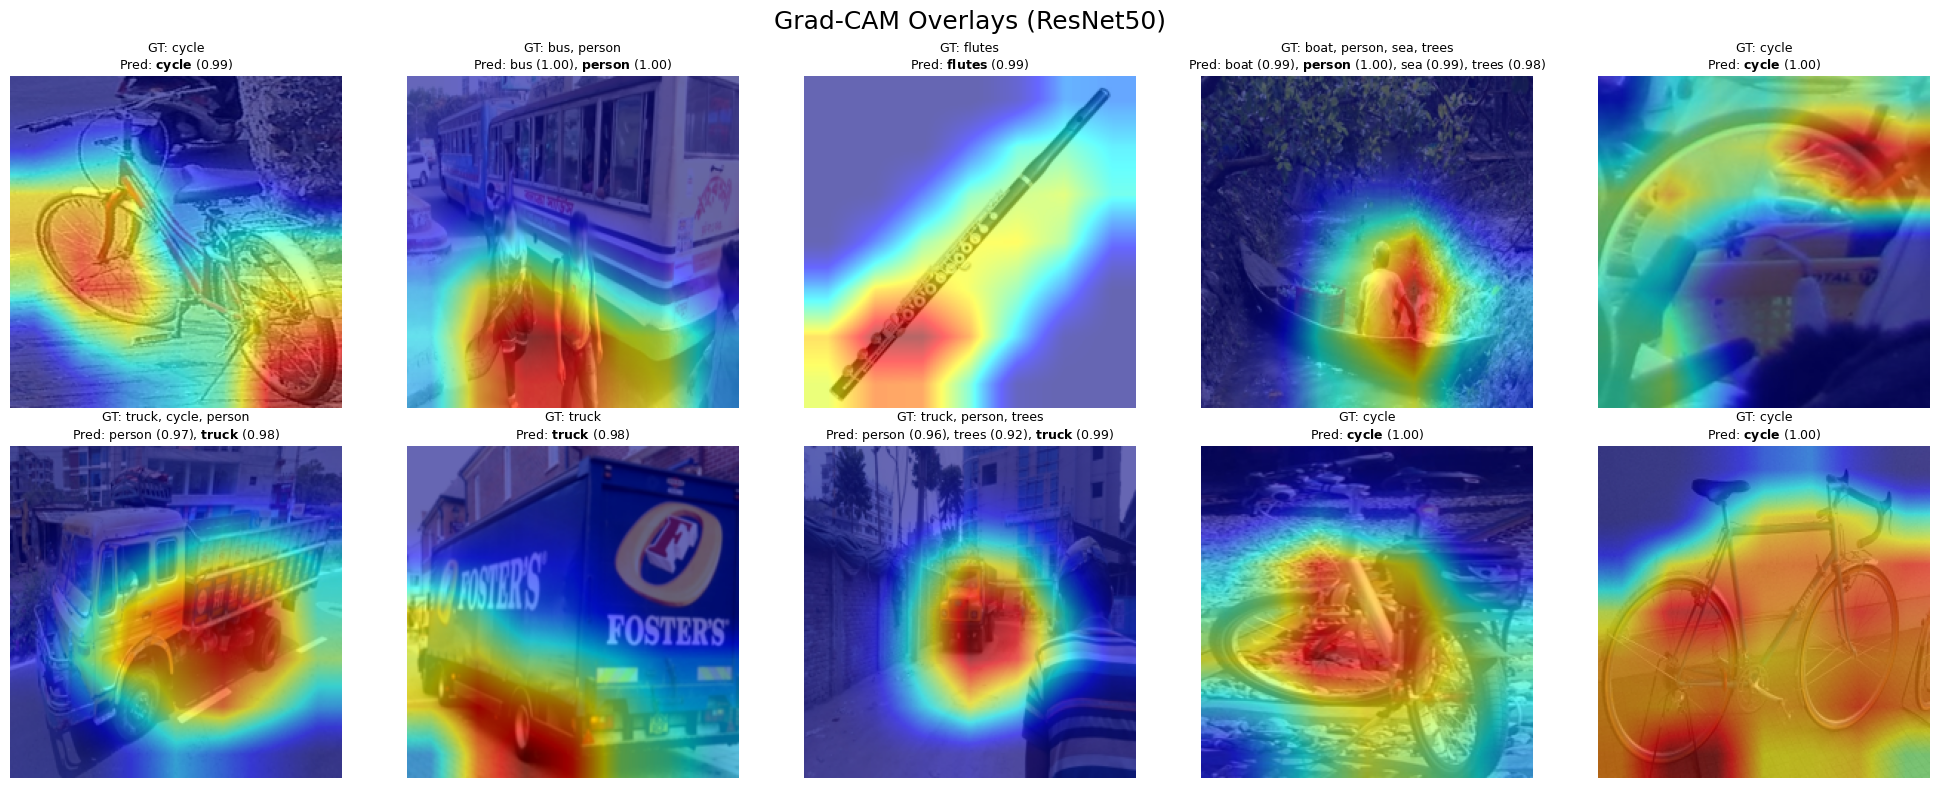

In [ ]:
unique_files = df[filename_col].unique()
num_samples = min(10, len(unique_files))
sampled_files = np.random.choice(unique_files, num_samples, replace=False)

overlays = []
titles = []

for img_name in sampled_files:
    row = df[df[filename_col] == img_name].iloc[0]  # first occurrence of this image
    img_path = images_folder + img_name
    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # --- Ground Truth Labels ---
    gt_labels = row['Labels']
    if isinstance(gt_labels, list):
        gt_labels_str = ", ".join(gt_labels)
    else:
        gt_labels_str = str(gt_labels)

    # --- Predict (multi-label) ---
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.sigmoid(outputs)[0].cpu().numpy()
    # Multi-label: show all labels with probability > 0.5
    pred_idxs = np.where(probs > 0.5)[0]
    # For GradCAM, use the most confident class
    target_class_idx = int(np.argmax(probs))

    if len(pred_idxs) == 0:
        pred_label_str = "(none)"
    else:
        label_strings = []
        for i in pred_idxs:
            label = label_columns[i]
            conf = probs[i]
            if i == target_class_idx:
                # Bold the most important label using LaTeX-style
                label_str = r"$\bf{" + f"{label}" + "}$" + f" ({conf:.2f})"
            else:
                label_str = f"{label} ({conf:.2f})"
            label_strings.append(label_str)
        pred_label_str = ", ".join(label_strings)

    # --- Grad-CAM ---
    grad_cam = GradCAM_mine(model, model.layer4[-1])
    _ = model(input_tensor)
    heatmap = grad_cam(input_tensor, class_idx=target_class_idx)
    grad_cam.remove_hooks()

    # --- Prepare image array ---
    img = np.array(image.resize((224, 224)))
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    if img.shape[2] == 4:
        img = img[:, :, :3]
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)

    # --- Resize heatmap and overlay ---
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_amp = np.power(heatmap_resized, 1.5)
    heatmap_bgr = cv2.applyColorMap(np.uint8(255 * heatmap_amp), cv2.COLORMAP_JET)
    heatmap_rgb = cv2.cvtColor(heatmap_bgr, cv2.COLOR_BGR2RGB)
    overlayed = cv2.addWeighted(img, 0.4, heatmap_rgb, 0.6, 0)
    overlays.append(overlayed)

    # --- Title: ground truth and predicted ---
    titles.append(f"GT: {gt_labels_str}\nPred: {pred_label_str}")

# --- Plot overlays in a grid ---
cols = 5
rows = math.ceil(num_samples / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

for ax, ov, ttl in zip(axes, overlays, titles):
    ax.imshow(ov)
    # Use "usetex=False" to ensure the font weight works without LaTeX installed
    ax.set_title(ttl, fontsize=9, usetex=False)
    ax.axis("off")

for ax in axes[num_samples:]:
    ax.axis('off')

plt.suptitle("Grad-CAM Overlays (ResNet50)", fontsize=18)
plt.tight_layout()
plt.show()


### Explaining Predictions from Ensemble Model (Average)

In this section, we generate Grad-CAM heatmaps for an ensemble of diverse models—including ResNet50, EfficientNet-B0, ViT-B16, and DeiT. Each model performs prediction and produces a Grad-CAM heatmap for the same target class. These heatmaps are resized and averaged to produce a unified ensemble-level visualization, highlighting the most salient image regions across models. DenseNet121 was initially considered but excluded due to inconsistent behavior during hook registration and challenges in producing spatially aligned activations, which made it less suitable for Grad-CAM integration. The final overlay offers a more robust and explainability explanation, reflecting the collective attention of the ensemble.

In [ ]:
def set_relu_inplace_false(model):
    for module in model.modules():
        if isinstance(module, torch.nn.ReLU):
            module.inplace = False

# After you load densenet:
set_relu_inplace_false(densenet)

In [ ]:
def patch_densenet_relu(model):
    for module in model.features.modules():
        if isinstance(module, torch.nn.ReLU):
            module.inplace = False

patch_densenet_relu(densenet)

In [83]:
ensemble_models = [resnet, densenet, efficientnet, vit, deit]

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(label_columns) 

# Load ResNet
resnet = resnet50(pretrained=False)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
resnet.load_state_dict(torch.load('fine_resnet50.pth'))
resnet.to(device)
resnet.eval()

# Load DenseNet
densenet.load_state_dict(torch.load('fine_densenet121.pth'))
set_relu_inplace_false(densenet)
densenet.to(device)
densenet.eval()
def patch_densenet_relu(model):
    for module in model.features.modules():
        if isinstance(module, torch.nn.ReLU):
            module.inplace = False
patch_densenet_relu(densenet)


# Load EfficientNet
efficientnet = create_model('efficientnet_b0', pretrained=False, num_classes=num_classes)
efficientnet.load_state_dict(torch.load('fine_efficientb0.pth'))
efficientnet.to(device)
efficientnet.eval()

# Load ViT
vit = vit_b_16(pretrained=False)  # no need pretrained, since you are loading your weights
vit.heads.head = torch.nn.Linear(vit.heads.head.in_features, num_classes)
vit.load_state_dict(torch.load('fine_vit.pth'))
vit.to(device)
vit.eval()

# Load DeiT
deit = create_model('deit_base_patch16_224', pretrained=False, num_classes=num_classes)
deit.load_state_dict(torch.load('fine_deit.pth'))
deit.to(device)
deit.eval()


/tmp/ipykernel_2936302/2267166309.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load('fine_resnet50.pth'))
/tmp/ipykernel_2936302/22671663

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

Heatmap 0 shape: (7, 7)
Heatmap 1 shape: (7, 7)
Heatmap 2 shape: (27, 27)
Heatmap 3 shape: (27, 27)


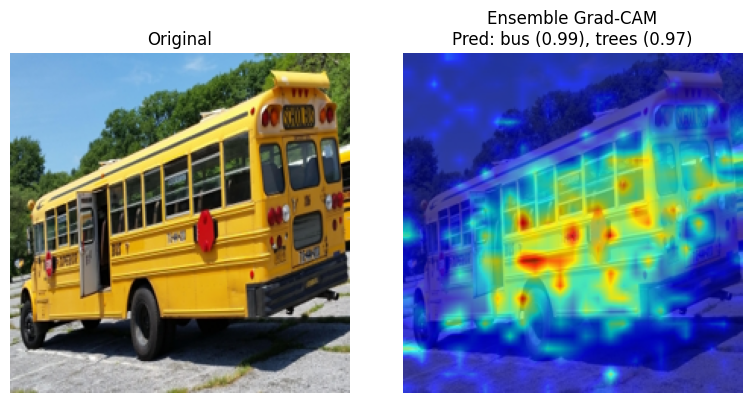

In [ ]:
# ---- Prepare your models in a list and choose layers for Grad-CAM ----
ensemble_models = [
    resnet,       # ResNet50
    # densenet,     # DenseNet121
    efficientnet, # EfficientNet-B0
    vit,          # ViT-B16
    deit          # DeiT-Base
]
gradcam_layers = [
    resnet.layer4[-1],                  # ResNet: last Bottleneck
    # densenet.features[-1],              # DenseNet: last DenseLayer
    efficientnet.conv_head,             # EfficientNet: last conv layer
    vit.encoder.layers[-1],             # ViT: last Transformer block (timm ViT)
    deit.blocks[-1]                     # DeiT: last Transformer block (timm DeiT)
]

class GradCAM_mine:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_full_backward_hook(backward_hook))
    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()
    def __call__(self, image_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(image_tensor)
        loss = output[0, class_idx]
        loss.backward()
        grads = self.gradients
        acts = self.activations[0]
        if grads.ndim == 4:  # CNN case
            pooled_gradients = torch.mean(grads, dim=[0, 2, 3])
            for i in range(acts.shape[0]):
                acts[i, :, :] *= pooled_gradients[i]
            heatmap = acts.sum(dim=0).cpu()
        elif grads.ndim == 3:  # Transformer, patch tokens
            # Usually acts shape [C, num_patches]
            pooled_gradients = torch.mean(grads, dim=2)
            acts = acts  # [C, num_patches]
            for i in range(acts.shape[0]):
                acts[i, :] *= pooled_gradients[0, i]
            heatmap = acts.sum(dim=0).cpu()
            num_patches = heatmap.shape[0]
            grid_size = int(num_patches ** 0.5)
            heatmap = heatmap[:grid_size*grid_size].reshape(grid_size, grid_size)
        else:
            raise ValueError("Unexpected grads shape: {}".format(grads.shape))
        heatmap = np.maximum(heatmap, 0)
        heatmap /= heatmap.max() if heatmap.max() != 0 else 1
        return heatmap.numpy()


def get_ensemble_preds_and_heatmaps(models, layers, input_tensor, target_class_idx):
    heatmaps = []
    preds = []
    for model, layer in zip(models, layers):
        # Prediction (needed to keep each model's output)
        model.eval()
        with torch.no_grad():
            out = torch.sigmoid(model(input_tensor))
            preds.append(out[0].cpu().numpy())

        # Grad-CAM
        grad_cam = GradCAM_mine(model, layer)
        _ = model(input_tensor)  # Forward pass for hooks
        heatmap = grad_cam(input_tensor, class_idx=target_class_idx)
        grad_cam.remove_hooks()
        heatmaps.append(heatmap)
    return preds, heatmaps

# ---- Example usage for a single image ----
idx = 3  # <-- or any valid index
row = df.iloc[idx]
img_name = row[filename_col]
img_path = images_folder + img_name
image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)

# 1. Ensemble prediction (average)
all_preds = []
for model in ensemble_models:
    model.eval()
    with torch.no_grad():
        out = torch.sigmoid(model(input_tensor))
        all_preds.append(out[0].cpu().numpy())
all_preds = np.stack(all_preds)
ensemble_probs = np.mean(all_preds, axis=0)

# Multi-label: get all labels > 0.5
pred_idxs = np.where(ensemble_probs > 0.5)[0]
if len(pred_idxs) == 0:
    pred_label_str = "(none)"
else:
    pred_label_str = ", ".join(f"{label_columns[i]} ({ensemble_probs[i]:.2f})" for i in pred_idxs)
# For GradCAM, use the class with highest mean probability
target_class_idx = int(np.argmax(ensemble_probs))

# 2. Get Grad-CAMs for each model for the **same target class**
_, all_heatmaps = get_ensemble_preds_and_heatmaps(
    ensemble_models, gradcam_layers, input_tensor, target_class_idx=target_class_idx
)
desired_shape = (224, 224)  # or whatever your input image shape is
heatmaps_resized = []
for idx, hm in enumerate(all_heatmaps):
    hm_resized = cv2.resize(hm, desired_shape, interpolation=cv2.INTER_LINEAR)
    heatmaps_resized.append(hm_resized)
avg_heatmap = np.mean(heatmaps_resized, axis=0)

for idx, hm in enumerate(all_heatmaps):
    print(f"Heatmap {idx} shape: {hm.shape}")

# 3. Average GradCAMs
# avg_heatmap = np.mean([hm for hm in all_heatmaps], axis=0)
# Resize for overlay
# img = np.array(image.resize((224, 224)))
# if img.ndim == 2:
#     img = np.stack([img]*3, axis=-1)
# if img.shape[2] == 4:
#     img = img[:, :, :3]
# if img.dtype != np.uint8:
#     img = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)

# heatmap_resized = cv2.resize(avg_heatmap, (img.shape[1], img.shape[0]))
# heatmap_amp = np.power(heatmap_resized, 1.5)
# heatmap_bgr = cv2.applyColorMap(np.uint8(255 * heatmap_amp), cv2.COLORMAP_JET)
# heatmap_rgb = cv2.cvtColor(heatmap_bgr, cv2.COLOR_BGR2RGB)
# overlayed = cv2.addWeighted(img, 0.4, heatmap_rgb, 0.6, 0)


# 3. Average GradCAMs
# avg_heatmap = np.mean([hm for hm in all_heatmaps], axis=0)

img = np.array(image.resize((224, 224)))
if img.ndim == 2:
    img = np.stack([img]*3, axis=-1)
if img.shape[2] == 4:
    img = img[:, :, :3]
if img.dtype != np.uint8:
    img = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)

# --- Normalize and boost the heatmap ---
heatmap_resized = cv2.resize(avg_heatmap, (img.shape[1], img.shape[0]))
hm = heatmap_resized.copy()
hm -= hm.min()
hm /= (hm.max() + 1e-8)
hm = np.power(hm, 1.7)  # Try 1.5–2.0 for more/less contrast
hm = np.clip(hm, 0, 1)

# --- Colorize and overlay ---
hm_uint8 = np.uint8(255 * hm)
heatmap_bgr = cv2.applyColorMap(hm_uint8, cv2.COLORMAP_JET)
heatmap_rgb = cv2.cvtColor(heatmap_bgr, cv2.COLOR_BGR2RGB)
overlayed = cv2.addWeighted(img, 0.3, heatmap_rgb, 0.7, 0)


# 4. Show!
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis("off")
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(overlayed)
plt.axis("off")
plt.title(f"Ensemble Grad-CAM\nPred: {pred_label_str}")
plt.tight_layout()
plt.show()

We generate Grad-CAM overlays for an ensemble of CNNs and Transformers across multiple images. Each model contributes a heatmap for the most confident predicted class, and these are averaged to highlight common salient regions. (DenseNet was excluded due to difficulties in extracting spatially consistent activations, which hindered reliable visualization).

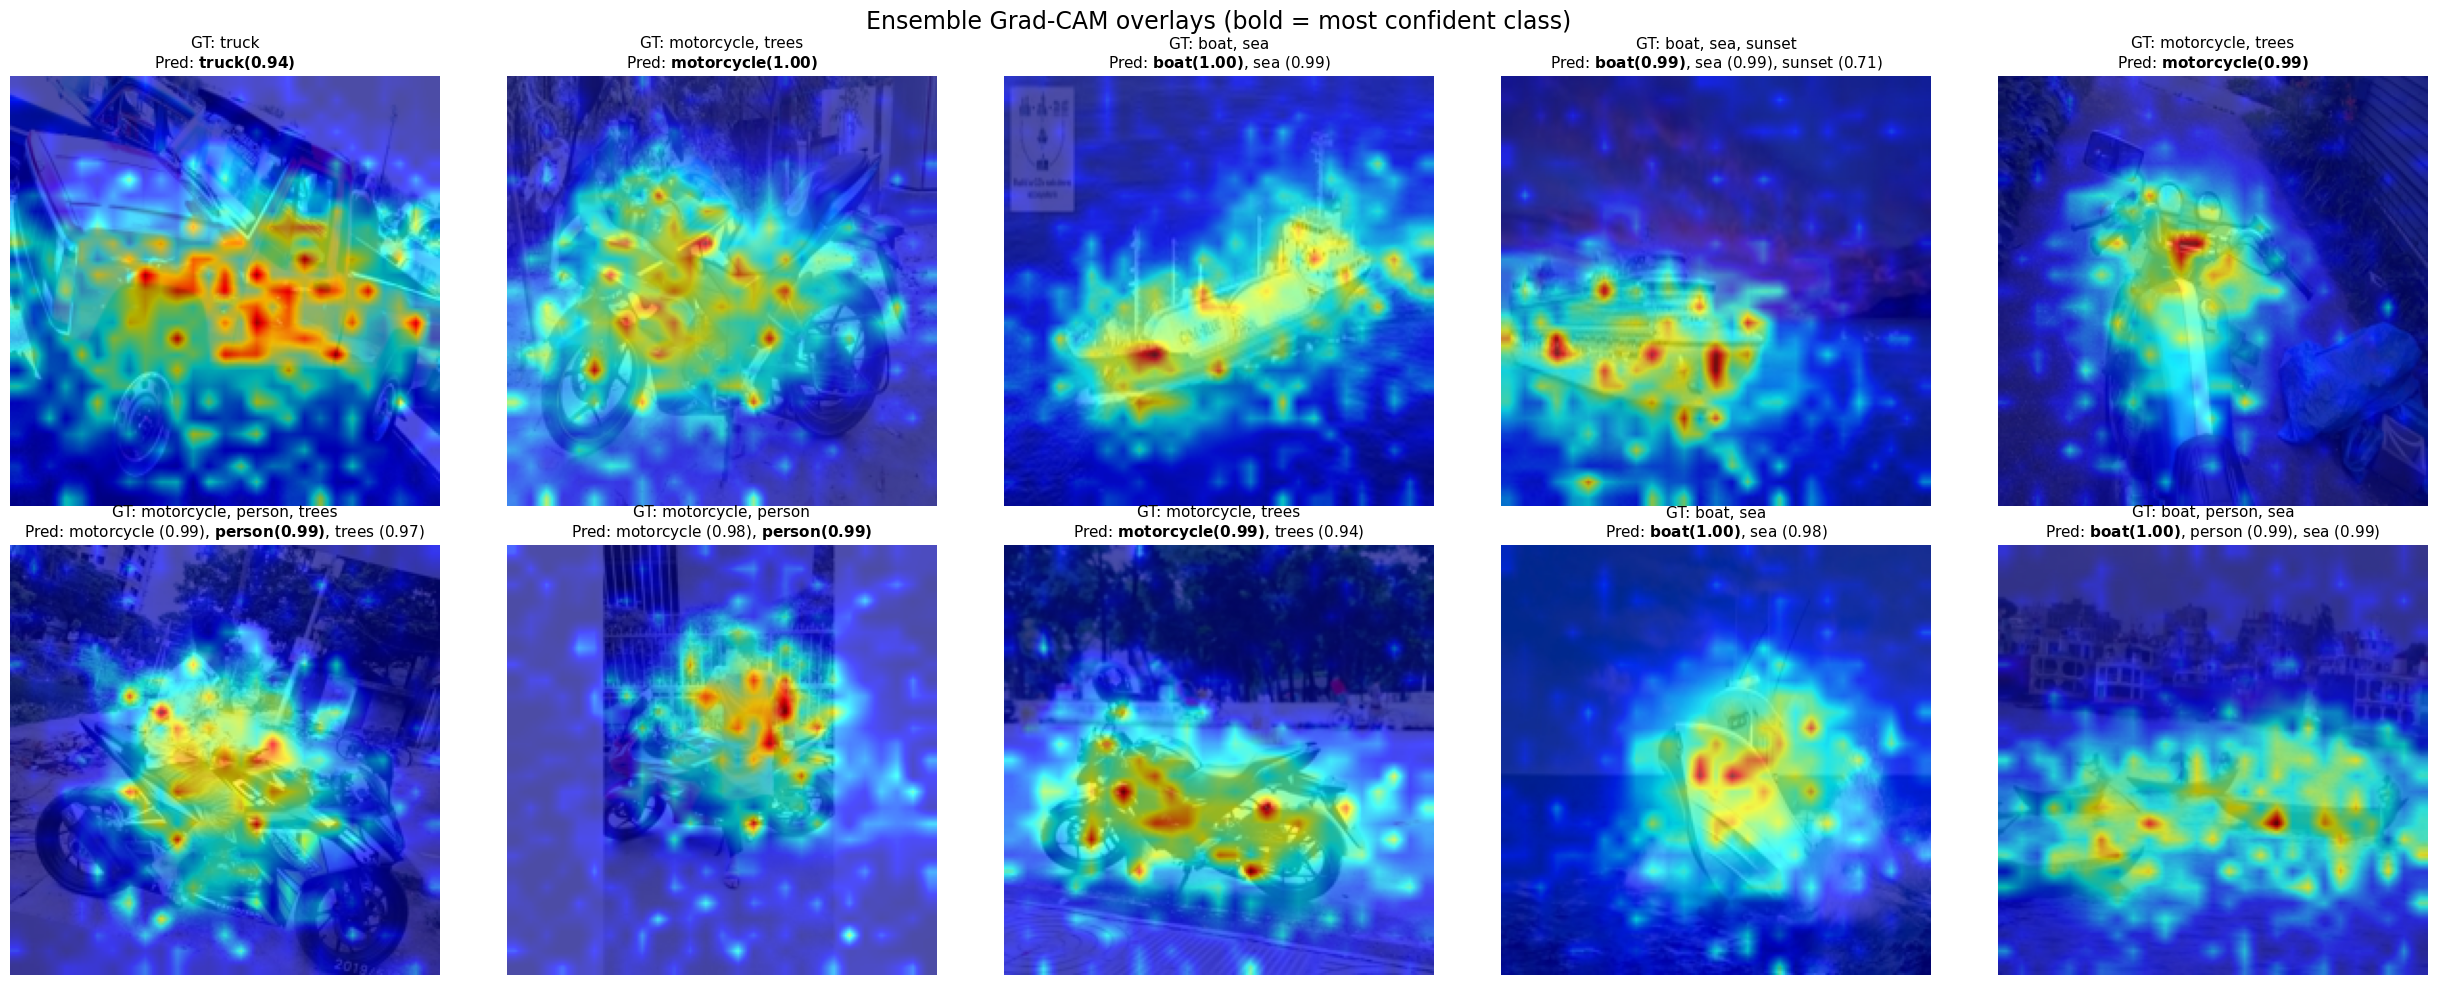

In [ ]:
# ---- Prepare your models in a list and choose layers for Grad-CAM ----
ensemble_models = [
    resnet,       # ResNet50
    # densenet,     # DenseNet121
    efficientnet, # EfficientNet-B0
    vit,          # ViT-B16
    deit          # DeiT-Base
]
gradcam_layers = [
    resnet.layer4[-1],                  # ResNet: last Bottleneck
    # densenet.features[-1],              # DenseNet: last DenseLayer
    efficientnet.conv_head,             # EfficientNet: last conv layer
    vit.encoder.layers[-1],             # ViT: last Transformer block (timm ViT)
    deit.blocks[-1]                     # DeiT: last Transformer block (timm DeiT)
]

class GradCAM_mine:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_full_backward_hook(backward_hook))
    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()
    def __call__(self, image_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(image_tensor)
        loss = output[0, class_idx]
        loss.backward()
        grads = self.gradients
        acts = self.activations[0]
        if grads.ndim == 4:  # CNN case
            pooled_gradients = torch.mean(grads, dim=[0, 2, 3])
            for i in range(acts.shape[0]):
                acts[i, :, :] *= pooled_gradients[i]
            heatmap = acts.sum(dim=0).cpu()
        elif grads.ndim == 3:  # Transformer, patch tokens
            pooled_gradients = torch.mean(grads, dim=2)
            for i in range(acts.shape[0]):
                acts[i, :] *= pooled_gradients[0, i]
            heatmap = acts.sum(dim=0).cpu()
            num_patches = heatmap.shape[0]
            grid_size = int(num_patches ** 0.5)
            heatmap = heatmap[:grid_size*grid_size].reshape(grid_size, grid_size)
        else:
            raise ValueError("Unexpected grads shape: {}".format(grads.shape))
        heatmap = np.maximum(heatmap, 0)
        heatmap /= heatmap.max() if heatmap.max() != 0 else 1
        return heatmap.numpy()

def get_ensemble_preds_and_heatmaps(models, layers, input_tensor, target_class_idx):
    heatmaps = []
    preds = []
    for model, layer in zip(models, layers):
        # Prediction (needed to keep each model's output)
        model.eval()
        with torch.no_grad():
            out = torch.sigmoid(model(input_tensor))
            preds.append(out[0].cpu().numpy())
        # Grad-CAM
        grad_cam = GradCAM_mine(model, layer)
        _ = model(input_tensor)  # Forward pass for hooks
        heatmap = grad_cam(input_tensor, class_idx=target_class_idx)
        grad_cam.remove_hooks()
        heatmaps.append(heatmap)
    return preds, heatmaps

# ---- Loop over 10 images ----
num_show = 10
rows, cols = 2, 5  # (2x5 grid)

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
axes = axes.flatten()

indices = np.random.choice(len(df), num_show, replace=False)  # Unique images

for ax, idx in zip(axes, indices):
    row = df.iloc[idx]
    img_name = row[filename_col]
    img_path = images_folder + img_name
    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # 1. Ensemble prediction (average)
    all_preds = []
    for model in ensemble_models:
        model.eval()
        with torch.no_grad():
            out = torch.sigmoid(model(input_tensor))
            all_preds.append(out[0].cpu().numpy())
    all_preds = np.stack(all_preds)
    ensemble_probs = np.mean(all_preds, axis=0)

    # Multi-label: get all labels > 0.5
    pred_idxs = np.where(ensemble_probs > 0.5)[0]
    target_class_idx = int(np.argmax(ensemble_probs))
    # --- Pred label string, bold for argmax
    pred_label_strs = []
    for i in pred_idxs:
        lbl = label_columns[i]
        p = ensemble_probs[i]
        if i == target_class_idx:
            pred_label_strs.append(r"$\bf{" + f"{lbl} ({p:.2f})" + "}$")
        else:
            pred_label_strs.append(f"{lbl} ({p:.2f})")
    if pred_label_strs:
        pred_label_str = ", ".join(pred_label_strs)
    else:
        pred_label_str = "(none)"

    # 2. Get Grad-CAMs for each model for the **same target class**
    _, all_heatmaps = get_ensemble_preds_and_heatmaps(
        ensemble_models, gradcam_layers, input_tensor, target_class_idx=target_class_idx
    )
    desired_shape = (224, 224)
    heatmaps_resized = [cv2.resize(hm, desired_shape, interpolation=cv2.INTER_LINEAR) for hm in all_heatmaps]
    avg_heatmap = np.mean(heatmaps_resized, axis=0)

    # 3. Overlay
    img = np.array(image.resize((224, 224)))
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    if img.shape[2] == 4:
        img = img[:, :, :3]
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)
    # --- Normalize and boost the heatmap ---
    hm = avg_heatmap.copy()
    hm -= hm.min()
    hm /= (hm.max() + 1e-8)
    hm = np.power(hm, 1.7)
    hm = np.clip(hm, 0, 1)
    # --- Colorize and overlay ---
    hm_uint8 = np.uint8(255 * hm)
    heatmap_bgr = cv2.applyColorMap(hm_uint8, cv2.COLORMAP_JET)
    heatmap_rgb = cv2.cvtColor(heatmap_bgr, cv2.COLOR_BGR2RGB)
    overlayed = cv2.addWeighted(img, 0.3, heatmap_rgb, 0.7, 0)
    # --- Show ---
    ax.imshow(overlayed)
    gt_labels = row['Labels']
    if isinstance(gt_labels, list):
        gt_str = ", ".join(str(x) for x in gt_labels)
    else:
        gt_str = str(gt_labels)
    ax.set_title(f"GT: {gt_str}\nPred: {pred_label_str}", fontsize=11)
    ax.axis("off")

for ax in axes[num_show:]:
    ax.axis('off')
plt.suptitle("Ensemble Grad-CAM overlays (bold = most confident class)", fontsize=17)
plt.tight_layout()
plt.show()


## Semi Supervised Learning 

### 1. Preparing Labeled and Unlabeled Data

To simulate a semi-supervised setting, we split the labeled dataset into two parts:
- A small labeled subset (20%)
- A large pseudo-unlabeled subset (80%)

The labeled subset is used for initial supervised training. The unlabeled subset will later receive pseudo-labels from the trained model.

In [ ]:
# Split labeled data into a smaller labeled set and a pseudo-unlabeled set
labeled_df, unlabeled_df = train_test_split(train_df, test_size=0.8, random_state=42)

print(f"Number of labeled samples: {len(labeled_df)}")
print(f"Number of unlabeled samples: {len(unlabeled_df)}")

In [18]:
supervised_dataset = MultiLabelDataset(labeled_df,transform=simple_transform)
supervised_loader = DataLoader(supervised_dataset, batch_size=32, shuffle=True)

In [24]:
val_dataset = MultiLabelDataset(val_df, transform=simple_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

### 2. Supervised Training on Small Labeled Set

We define and train a ResNet-50 model using only the small labeled subset. This model serves as the foundation for generating pseudo-labels.

- Replace the final fully-connected layer for multi-label classification
- Train using Binary Cross-Entropy with Logits loss
- Evaluate the model on a held-out validation set after each epoch

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize and train the supervised model
supervised_model = resnet50(pretrained=True)
supervised_model.fc = nn.Linear(supervised_model.fc.in_features, len(label_columns))
supervised_model = supervised_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(supervised_model.parameters(), lr=1e-4)


num_epochs = 5
for epoch in range(num_epochs):
    supervised_model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in supervised_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = supervised_model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(supervised_loader):.4f}")

    # Validation phase
    supervised_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = supervised_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")

torch.save(supervised_model.state_dict(), "supervised_model.pth")


/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 0.3003
Validation Loss: 0.1295
Epoch [2/5], Loss: 0.0951
Validation Loss: 0.0947
Epoch [3/5], Loss: 0.0603
Validation Loss: 0.0909
Epoch [4/5], Loss: 0.0430
Validation Loss: 0.0856
Epoch [5/5], Loss: 0.0320
Validation Loss: 0.0866


### 4. Preparing the Unlabeled Dataset

We define a custom `UnlabeledDataset` class that loads images from the pseudo-unlabeled subset. These images will be passed through the supervised model to generate pseudo-labels.


In [26]:
class UnlabeledDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.img_paths = dataframe['full_path'].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_path 


### 5. Pseudo-Label Generation

We define a function to generate pseudo-labels for the unlabeled data using the trained supervised model.

For each image:
- Model outputs are passed through a sigmoid activation
- Predictions above a confidence threshold (0.8) are selected
- Only images with at least one confident label are included

This results in a filtered set of pseudo-labeled images for semi-supervised training.

In [27]:
def generate_pseudo_labels(model, unlabeled_loader, threshold=0.8):
    """
    Generate pseudo-labels for unlabeled data based on model confidence.
    Args:
        model: Trained model.
        unlabeled_loader: DataLoader for unlabeled dataset.
        threshold: Confidence threshold for pseudo-labels.
    Returns:
        List of pseudo-labeled image paths and their pseudo-labels.
    """
    model.eval()
    pseudo_images = []  # This should store image file paths (strings)
    pseudo_labels = []  # This should store the corresponding pseudo-labels

    with torch.no_grad():
        for batch in unlabeled_loader:
            images, paths = batch  # Ensure paths are strings
            images = images.to(device)
            outputs = torch.sigmoid(model(images))  # Get probabilities
            preds = (outputs > threshold).float()  # Apply confidence threshold

            for i in range(images.size(0)):
                if preds[i].sum() > 0:  # Ensure at least one confident label
                    pseudo_images.append(paths[i])  # Store the image path (string)
                    pseudo_labels.append(preds[i].cpu().numpy())  # Store the pseudo-label

    return pseudo_images, pseudo_labels



In [31]:
unlabeled_dataset = UnlabeledDataset(unlabeled_df, transform=simple_transform)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=False)

In [32]:
pseudo_images, pseudo_labels = generate_pseudo_labels(supervised_model, unlabeled_loader, threshold=0.8)

print(f"Generated {len(pseudo_images)} pseudo-labeled samples.")
print("First few pseudo-labels:")
for i in range(5):
    print(f"Image Path: {pseudo_images[i]}, Pseudo-Labels: {pseudo_labels[i]}")

Generated 3626 pseudo-labeled samples.
First few pseudo-labels:
Image Path: /home/annachatz/Deep Learning/multilabel_modified/images/image4387.jpg, Pseudo-Labels: [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Image Path: /home/annachatz/Deep Learning/multilabel_modified/images/image6034.jpg, Pseudo-Labels: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Image Path: /home/annachatz/Deep Learning/multilabel_modified/images/image2042.jpg, Pseudo-Labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Image Path: /home/annachatz/Deep Learning/multilabel_modified/images/image1932.jpg, Pseudo-Labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Image Path: /home/annachatz/Deep Learning/multilabel_modified/images/image2967.jpg, Pseudo-Labels: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### 6. Creating the Pseudo-Labeled Dataset

Using the pseudo-labeled image paths and their predicted labels, we define a new dataset class that wraps these examples into a PyTorch-compatible dataset.

In [35]:
class PseudoLabeledDataset(Dataset):
    def __init__(self, image_paths, pseudo_labels, transform=None):
        self.image_paths = image_paths
        self.pseudo_labels = pseudo_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label    = torch.tensor(self.pseudo_labels[idx], dtype=torch.float32)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label


pseudo_dataset = PseudoLabeledDataset(
    image_paths   = pseudo_images, 
    pseudo_labels = pseudo_labels, 
    transform     = simple_transform
)

In [36]:
from torch.utils.data import ConcatDataset

### 7. Combining Labeled and Pseudo-Labeled Data

We concatenate the original labeled dataset with the pseudo-labeled dataset to form a single combined training set. This larger dataset will be used to train a new model in a semi-supervised fashion.

In [ ]:
combined_dataset = ConcatDataset([supervised_dataset, pseudo_dataset])
combined_loader  = DataLoader(
    combined_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True
)

### 8. Semi-Supervised Model Training

We define and train a new ResNet-50 model on the combined dataset.

By incorporating pseudo-labeled examples, the model benefits from additional training data and improves its generalization ability.

As before, the model is evaluated on the validation set after each epoch.

In [38]:
# ——— Model setup ———
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
semi_supervised_model  = resnet50(pretrained=True)
semi_supervised_model.fc = nn.Linear(semi_supervised_model.fc.in_features, len(label_columns))
semi_supervised_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(semi_supervised_model.parameters(), lr=1e-4)


num_epochs = 5

for epoch in range(num_epochs):
    # ——— Training Phase ———
    semi_supervised_model.train()
    running_loss = 0.0

    for images, labels in combined_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = semi_supervised_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(combined_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {avg_train_loss:.4f}")

    # ——— Validation Phase ———
    semi_supervised_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = semi_supervised_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}]  Val   Loss: {avg_val_loss:.4f}")

# ——— Save Model ———
torch.save(semi_supervised_model.state_dict(), 'resnet50_semi_supervised.pth')
print("Model saved successfully!")


/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5]  Train Loss: 0.1211
Epoch [1/5]  Val   Loss: 0.0924
Epoch [2/5]  Train Loss: 0.0393
Epoch [2/5]  Val   Loss: 0.1071
Epoch [3/5]  Train Loss: 0.0255
Epoch [3/5]  Val   Loss: 0.1057
Epoch [4/5]  Train Loss: 0.0179
Epoch [4/5]  Val   Loss: 0.1101
Epoch [5/5]  Train Loss: 0.0143
Epoch [5/5]  Val   Loss: 0.1212
Model saved successfully!


In [ ]:
semi_supervised_model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(semi_supervised_model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))

              precision    recall  f1-score   support

        boat       0.99      0.96      0.97       237
         bus       0.95      0.97      0.96        92
       cycle       0.93      0.99      0.96       226
      ektara       1.00      0.45      0.62        22
      flutes       0.90      0.62      0.73        42
   harmonium       0.93      0.74      0.82        34
  motorcycle       0.99      0.82      0.90       159
   mountains       0.00      0.00      0.00        29
      person       0.91      0.63      0.75       332
         sea       0.95      0.92      0.93       240
       sitar       1.00      0.62      0.76        34
      sunset       0.83      0.33      0.48        15
       tabla       0.99      0.86      0.92       125
       trees       0.90      0.58      0.71       223
       truck       0.98      0.86      0.92       139

   micro avg       0.95      0.79      0.86      1949
   macro avg       0.88      0.69      0.76      1949
weighted avg       0.93   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
